<a href="https://colab.research.google.com/github/HazelvdW/context-framed-listening/blob/main/framed_listening_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framed Listening: **Word2Vec analyses**
> By **Hazel A. van der Walle** (PhD student, Music, Durham University), September 2025.

This notebook analyses semantic similarity between music-evoked thought (MET)
descriptions to answer: "Does context cue influence METs more than the music itself?"

Analysis approach:
- Works with individual thought descriptions (N=1962) and aggregated documents (called "METdocs")
- Calculates pairwise cosine similarities between all individual thoughts and between METdocs
- Categorises pairs by their stimuli conditions to compare similarity distributions
- Tests whether thoughts are more similar when sharing music vs sharing context

Key comparisons:
1. Same clip + different context VS Different clip + same context
   → Does music or context drive thought similarity?
2. Within vs between genre/context/clip conditions
   → What factors influence semantic coherence in METs?

---

All datasets generated and used for this study are openly available on GitHub https://github.com/HazelvdW/context-framed-listening.

In [ ]:
!rm -r context-framed-listening
# Clone the GitHub repository
!git clone https://github.com/HazelvdW/context-framed-listening.git

Refresh files to see **"context-framed-listening"**.


---

## Setup

In [ ]:
import os
import csv
import pandas as pd
import numpy as np

!pip install gensim
import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

The Github repo for Word2Vec model pretrained trained on Google News was accessed via https://github.com/mmihaltz/word2vec-GoogleNews-vectors/ (September 2025).
>I downloaded `GoogleNews-vectors-negative300.bin.gz` to my Google Drive for use here.

>You can follow the commented out code below to mount your Drive, _or_ you can mount it manually by selecting the File icon on the left-side menu followed by the drive symbol next the 'Refresh'. [Change the pathname as needed.]

Load up the pretrained Google word2vec embeddings:

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # < this will ask you to log into your account

# Load the pretrained Google Word2Vec model
print("Loading Pretrained Word2Vec model...")
model_word2vec = gensim.models.KeyedVectors.load_word2vec_format(
    '/content/drive/MyDrive/Colab Notebooks/W2V_TFIDF/GoogleNews-vectors-negative300.bin.gz',
    binary=True
)
model_word2vec.fill_norms() # < normalises loaded word vectors (ensures vector lengths don't affect sim calcs)
print("✓ Model loaded successfully!")
print(f"Vocabulary size: {len(model_word2vec):,} words")
print(f"Vector dimensions: {model_word2vec.vector_size}")


# Function to get W2V embeddings for OOV words
def get_word2vec_embedding(text, model):
    """
    Get Word2Vec embedding for text by averaging word vectors.
    Handles words not in vocabulary.
    """
    word_vectors = []
    words_not_in_vocab = []

    tokens = nltk.word_tokenize(str(text))

    for word in tokens:
        try:
            word_vectors.append(model[word])
        except KeyError:
            words_not_in_vocab.append(word)

    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0), words_not_in_vocab
    else:
        return np.zeros(300), words_not_in_vocab

---
## ANALYSIS AT COMBINED METdoc

Measuring semantic similarity between agregated representations of conditions.

This is a complementary analysis to the individual MET level analyses above.
It aggregates thoughts into documents by clip-context pairs to examine condition-level semantic profiles. This is useful for comparison but the individual-level analysis is the primary approach for hypothesis testing.

Purpose: Compare semantic profiles at the document/condition level
- Each document = all thoughts from one clip-context pairing
- Shows overall semantic "signature" of each condition
- Useful for exploratory visualisation and pattern detection


In [ ]:
# Load aggregated METdocs
print("Loading aggregated METdocs...")
METdocs = pd.read_csv('/content/context-framed-listening/NLP_outputs/METdocsLVL2.csv')

# Use the Word2Vec-appropriate preprocessing column
text_column = 'METdescr_prepLVL2'

print(f"\nTotal METdocs (clip-context pairs): {len(METdocs)}")
print(f"Unique clips: {METdocs['clip_name'].nunique()}")
print(f"Unique contexts: {METdocs['context_word'].nunique()}")
print(f"Unique genres: {METdocs['genre_code'].nunique()}")

# Display sample
print("\nSample METdocs:")
display(METdocs[['ClipContext_pair', 'clip_name', 'context_word', 'genre_code']].head())

### Word2Vec embeddings

In [ ]:
print("\nComputing Word2Vec embeddings for aggregated METdocs...")

doc_embeddings = []
all_missing_words_docs = []

for idx, row in METdocs.iterrows():
    text = str(row[text_column])
    embedding, missing_words = get_word2vec_embedding(text, model_word2vec)
    doc_embeddings.append(embedding)
    all_missing_words_docs.extend(missing_words)

    if (idx + 1) % 10 == 0:
        print(f"  Processed {idx + 1}/{len(METdocs)} documents...")

doc_embeddings = np.array(doc_embeddings)

print(f"\n✓ Word2Vec embeddings computed")
print(f"  Embeddings shape: {doc_embeddings.shape}")
print(f"  Unique OOV words: {len(set(all_missing_words_docs)):,}")
print(f"  OOV rate: {len(all_missing_words_docs) / (len(METdocs) * 50):.1%}")  # rough estimate

# Save embeddings
print("\nSaving embeddings...")
np.save('/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_METdocs_embeddings.npy',
        doc_embeddings)
print("✓ Saved: W2V_METdocs_embeddings.npy")

### Cosine Similiarity Matrix

In [ ]:
print("\nCalculating pairwise similarities...")
cosineMatrix_W2V = cosine_similarity(doc_embeddings, doc_embeddings)

# Create labeled DataFrame
cosineMatrix_W2V_df = pd.DataFrame(
    cosineMatrix_W2V,
    index=METdocs['ClipContext_pair'],
    columns=METdocs['ClipContext_pair']
)

# Save
cosineMatrix_W2V_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_cosineMatrix.csv',
    encoding='utf-8'
)

print("\n✓ Cosine similarity matrix computed")
print(f"  Matrix shape: {cosineMatrix_W2V.shape}")
print(f"  Total pairwise comparisons: {(len(METdocs) * (len(METdocs) - 1)) // 2:,}")

print("\nWord2Vec Cosine Similarity Matrix (METdocs level):")
display(cosineMatrix_W2V_df.head())


# Visualize heatmap
print("\nGenerating similarity heatmap...")
plt.figure(figsize=(16, 14))
sns.heatmap(cosineMatrix_W2V_df, cmap='viridis', annot=False, square=True,
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('Word2Vec Cosine Similarity Matrix: Aggregated METdocs (Clip-Context Pairs)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_METdocs_heatmap.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: W2V_METdocs_heatmap.png")

### Similarity Values by Condition

In [ ]:
# Extract metadata
clips = METdocs['clip_name'].values
contexts = METdocs['context_word'].values
genres = METdocs['genre_code'].values

# Initialize storage
similarity_data = {
    'doc_i': [],
    'doc_j': [],
    'similarity': [],
    'same_clip': [],
    'same_context': [],
    'same_genre': [],
    'condition': []
}

# Process pairs
n_docs = len(METdocs)
print(f"\nProcessing {(n_docs * (n_docs - 1)) // 2:,} unique document pairs...")

for i in range(n_docs):
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{n_docs} documents...")

    for j in range(i + 1, n_docs):
        sim_value = cosineMatrix_W2V[i, j]

        same_clip = clips[i] == clips[j]
        same_context = contexts[i] == contexts[j]
        same_genre = genres[i] == genres[j]

        # Categorize (IDENTICAL to TF-IDF)
        if same_clip and same_context:
            condition = 'same_clip_same_context'
        elif same_clip and not same_context:
            condition = 'same_clip_diff_context'  # MUSIC influence
        elif not same_clip and same_context:
            condition = 'diff_clip_same_context'  # CONTEXT influence
        elif not same_clip and not same_context:
            if same_genre:
                condition = 'diff_clip_diff_context_same_genre'
            else:
                condition = 'diff_clip_diff_context_diff_genre'
        else:
            condition = 'other'

        similarity_data['doc_i'].append(i)
        similarity_data['doc_j'].append(j)
        similarity_data['similarity'].append(sim_value)
        similarity_data['same_clip'].append(same_clip)
        similarity_data['same_context'].append(same_context)
        similarity_data['same_genre'].append(same_genre)
        similarity_data['condition'].append(condition)

# Create DataFrame
sim_df_docs = pd.DataFrame(similarity_data)
sim_df_docs.to_csv(
    '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_similarity_by_condition.csv',
    index=False
)

print("\n✓ METdocs-level similarity measures extracted")
print("\nSummary by condition:")
summary = sim_df_docs.groupby('condition')['similarity'].agg(['count', 'mean', 'std', 'min', 'max'])
print(summary)

### Binary Comparisons

In [ ]:
print("\n" + "="*70)
print("BINARY COMPARISONS - Fundamental Effects")
print("="*70)
print("Testing whether sharing a factor (clip/context/genre) increases similarity")

# ---------------------------------------------------------------------------
# FUNCTION SET-UP
# ---------------------------------------------------------------------------
def compare_binary(df, column, label):
    """
    Compare same vs different for a binary factor.

    Parameters:
    -----------
    df : pd.DataFrame
        Similarity dataframe
    column : str
        Column name for binary comparison (e.g., 'same_clip')
    label : str
        Factor name for display

    Returns:
    --------
    dict : Comparison statistics
    """
    same_data = df[df[column] == True]['similarity']
    diff_data = df[df[column] == False]['similarity']

    t_stat, p_value = stats.ttest_ind(same_data, diff_data)
    pooled_std = np.sqrt((same_data.std()**2 + diff_data.std()**2) / 2)
    effect_size = (same_data.mean() - diff_data.mean()) / pooled_std

    if p_value < 0.001:
        sig_str = "***"
    elif p_value < 0.01:
        sig_str = "**"
    elif p_value < 0.05:
        sig_str = "*"
    else:
        sig_str = "n.s."

    return {
        'comparison': f"Same {label} vs Different {label}",
        'mean_same': same_data.mean(),
        'mean_diff': diff_data.mean(),
        'diff': same_data.mean() - diff_data.mean(),
        't': t_stat,
        'p': p_value,
        'sig': sig_str,
        'd': effect_size,
        'n_same': len(same_data),
        'n_diff': len(diff_data)
    }


binary_comparisons = []

# 1. CLIP EFFECT
print("\n1. CLIP EFFECT: Same Clip vs Different Clip")
print("-" * 70)
clip_comp = compare_binary(sim_df_docs, 'same_clip', 'Clip')
binary_comparisons.append(clip_comp)

print(f"Same clip: M={clip_comp['mean_same']:.4f}, SD={sim_df_docs[sim_df_docs['same_clip']]['similarity'].std():.4f} (N={clip_comp['n_same']})")
print(f"Different clip: M={clip_comp['mean_diff']:.4f}, SD={sim_df_docs[~sim_df_docs['same_clip']]['similarity'].std():.4f} (N={clip_comp['n_diff']})")
print(f"Difference: {clip_comp['diff']:.4f}")
print(f"t({clip_comp['n_same'] + clip_comp['n_diff'] - 2}) = {clip_comp['t']:.3f}, p = {clip_comp['p']:.4f} {clip_comp['sig']}")
print(f"Cohen's d = {clip_comp['d']:.3f}")

if clip_comp['mean_same'] > clip_comp['mean_diff']:
    print("→ Sharing the same CLIP significantly increases similarity")
else:
    print("→ Same clip does NOT significantly increase similarity")


# 2. CONTEXT EFFECT
print("\n\n2. CONTEXT EFFECT: Same Context vs Different Context")
print("-" * 70)
context_comp = compare_binary(sim_df_docs, 'same_context', 'Context')
binary_comparisons.append(context_comp)

print(f"Same context: M={context_comp['mean_same']:.4f}, SD={sim_df_docs[sim_df_docs['same_context']]['similarity'].std():.4f} (N={context_comp['n_same']})")
print(f"Different context: M={context_comp['mean_diff']:.4f}, SD={sim_df_docs[~sim_df_docs['same_context']]['similarity'].std():.4f} (N={context_comp['n_diff']})")
print(f"Difference: {context_comp['diff']:.4f}")
print(f"t({context_comp['n_same'] + context_comp['n_diff'] - 2}) = {context_comp['t']:.3f}, p = {context_comp['p']:.4f} {context_comp['sig']}")
print(f"Cohen's d = {context_comp['d']:.3f}")

if context_comp['mean_same'] > context_comp['mean_diff']:
    print("→ Sharing the same CONTEXT significantly increases similarity")
else:
    print("→ Same context does NOT significantly increase similarity")


# 3. GENRE EFFECT
print("\n\n3. GENRE EFFECT: Same Genre vs Different Genre")
print("-" * 70)
genre_comp = compare_binary(sim_df_docs, 'same_genre', 'Genre')
binary_comparisons.append(genre_comp)

print(f"Same genre: M={genre_comp['mean_same']:.4f}, SD={sim_df_docs[sim_df_docs['same_genre']]['similarity'].std():.4f} (N={genre_comp['n_same']})")
print(f"Different genre: M={genre_comp['mean_diff']:.4f}, SD={sim_df_docs[~sim_df_docs['same_genre']]['similarity'].std():.4f} (N={genre_comp['n_diff']})")
print(f"Difference: {genre_comp['diff']:.4f}")
print(f"t({genre_comp['n_same'] + genre_comp['n_diff'] - 2}) = {genre_comp['t']:.3f}, p = {genre_comp['p']:.4f} {genre_comp['sig']}")
print(f"Cohen's d = {genre_comp['d']:.3f}")

if genre_comp['mean_same'] > genre_comp['mean_diff']:
    print("→ Sharing the same GENRE significantly increases similarity")
else:
    print("→ Same genre does NOT significantly increase similarity")


# KEY COMPARISON
print("\n\n" + "="*70)
print("KEY FINDING: Comparing Binary Effects")
print("="*70)

effects = [
    ('CLIP', clip_comp['d'], clip_comp['diff']),
    ('CONTEXT', context_comp['d'], context_comp['diff']),
    ('GENRE', genre_comp['d'], genre_comp['diff'])
]
effects_sorted = sorted(effects, key=lambda x: abs(x[1]), reverse=True)

print("\nEffect sizes ranked (absolute Cohen's d):")
for i, (factor, d, diff) in enumerate(effects_sorted, 1):
    print(f"  {i}. {factor}: d = {d:.3f}, mean difference = {diff:.4f}")

print(f"\n→ {effects_sorted[0][0]} has the LARGEST effect on thought similarity")
print(f"→ {effects_sorted[1][0]} has a MODERATE effect")
print(f"→ {effects_sorted[2][0]} has the SMALLEST effect")


#### Visualization

In [ ]:
print("\nGenerating binary comparison visualization...")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Clip comparison
clip_data = sim_df_docs.copy()
clip_data['clip_label'] = clip_data['same_clip'].map({True: 'Same Clip', False: 'Different Clip'})
sns.violinplot(data=clip_data, x='clip_label', y='similarity',
               order=['Same Clip', 'Different Clip'], ax=axes[0],
               hue='clip_label', palette=['#95a5a6', '#3498db'])
axes[0].set_title('Clip Effect', fontsize=13, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Cosine Similarity (Word2Vec)', fontsize=11)
axes[0].text(0.5, 0.95, f"d = {clip_comp['d']:.3f} {clip_comp['sig']}",
             ha='center', va='top', transform=axes[0].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Context comparison
context_data = sim_df_docs.copy()
context_data['context_label'] = context_data['same_context'].map({True: 'Same Context', False: 'Different Context'})
sns.violinplot(data=context_data, x='context_label', y='similarity',
               order=['Same Context', 'Different Context'], ax=axes[1],
               hue='context_label', palette=['#e74c3c', '#95a5a6'])
axes[1].set_title('Context Effect', fontsize=13, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].text(0.5, 0.95, f"d = {context_comp['d']:.3f} {context_comp['sig']}",
             ha='center', va='top', transform=axes[1].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Genre comparison
genre_data = sim_df_docs.copy()
genre_data['genre_label'] = genre_data['same_genre'].map({True: 'Same Genre', False: 'Different Genre'})
sns.violinplot(data=genre_data, x='genre_label', y='similarity',
               order=['Same Genre', 'Different Genre'], ax=axes[2],
               hue='genre_label', palette=['#2ecc71', '#95a5a6'])
axes[2].set_title('Genre Effect', fontsize=13, fontweight='bold')
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].text(0.5, 0.95, f"d = {genre_comp['d']:.3f} {genre_comp['sig']}",
             ha='center', va='top', transform=axes[2].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_binary_comparisons.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: W2V_binary_comparisons.png")

### Factor-Specific Analyses

#### Function set-up

In [ ]:
def analyze_within_factor_similarity(sim_df, metadata, factor_column, factor_name):
    """
    Analyze within-factor similarity (e.g., same context/genre, different clips).

    Parameters:
    -----------
    sim_df : pd.DataFrame
        Similarity dataframe
    metadata : pd.DataFrame
        METdocs dataframe
    factor_column : str
        'context_word' or 'genre_code'
    factor_name : str
        'Context' or 'Genre' (for display)

    Returns:
    --------
    pd.DataFrame : Within-factor statistics
    """
    print(f"\n1. WITHIN-{factor_name.upper()} SIMILARITY")
    print("-" * 70)

    if factor_name == 'Context':
        print("When different music is heard with the same context, how similar are thoughts?")
        condition_filter = sim_df['condition'] == 'diff_clip_same_context'
    else:  # Genre
        print("When different clips from the same genre are heard, how similar are thoughts?")
        condition_filter = (sim_df['same_genre'] == True) & (sim_df['same_clip'] == False)

    within_results = []
    factors = metadata[factor_column].unique()

    for factor in factors:
        # Get similarity for same factor, different clips
        factor_sims = sim_df[
            condition_filter &
            (sim_df[f'{factor_column.split("_")[0]}_i'] == factor) &
            (sim_df[f'{factor_column.split("_")[0]}_j'] == factor)
        ]['similarity']

        if len(factor_sims) > 0:
            within_results.append({
                factor_name.lower(): factor,
                'mean': factor_sims.mean(),
                'std': factor_sims.std(),
                'n': len(factor_sims),
                'cv': factor_sims.std() / factor_sims.mean()
            })

            print(f"\n{factor.upper()}:")
            print(f"  Mean similarity: {factor_sims.mean():.4f}")
            print(f"  SD: {factor_sims.std():.4f}")
            print(f"  CV: {factor_sims.std() / factor_sims.mean():.4f}")
            print(f"  N pairs: {len(factor_sims)}")

    within_df = pd.DataFrame(within_results).sort_values('mean', ascending=False)

    print(f"\n{'-'*70}")
    print(f"RANKING: {factor_name}s by Thought Convergence")
    print("-"*70)
    for i, row in within_df.iterrows():
        print(f"  {i+1}. {row[factor_name.lower()].upper()}: M={row['mean']:.4f} (CV={row['cv']:.4f})")

    print(f"\n→ {within_df.iloc[0][factor_name.lower()].upper()} produces MOST similar thoughts")
    print(f"→ {within_df.iloc[-1][factor_name.lower()].upper()} produces MOST DIVERSE thoughts")

    return within_df


# ---------------------------------------------------------------------------
def analyze_pairwise_factor_comparisons(sim_df, metadata, factor_column, factor_name, within_df):
    """
    Pairwise comparisons between different factors.

    Returns:
    --------
    pd.DataFrame : Pairwise comparison statistics
    """
    print(f"\n\n2. PAIRWISE {factor_name.upper()} COMPARISONS")
    print("-" * 70)

    if factor_name == 'Context':
        condition_filter = sim_df['condition'] == 'diff_clip_same_context'
    else:  # Genre
        condition_filter = (sim_df['same_genre'] == True) & (sim_df['same_clip'] == False)

    factor_pairs = []
    factors_list = list(metadata[factor_column].unique())
    factor_key = factor_column.split('_')[0]

    for i, factor1 in enumerate(factors_list):
        for factor2 in factors_list[i+1:]:
            factor1_sims = sim_df[
                condition_filter &
                (sim_df[f'{factor_key}_i'] == factor1) &
                (sim_df[f'{factor_key}_j'] == factor1)
            ]['similarity']

            factor2_sims = sim_df[
                condition_filter &
                (sim_df[f'{factor_key}_i'] == factor2) &
                (sim_df[f'{factor_key}_j'] == factor2)
            ]['similarity']

            if len(factor1_sims) > 0 and len(factor2_sims) > 0:
                t_stat, p_val = stats.ttest_ind(factor1_sims, factor2_sims)
                pooled_std = np.sqrt((factor1_sims.std()**2 + factor2_sims.std()**2) / 2)
                effect_size = (factor1_sims.mean() - factor2_sims.mean()) / pooled_std

                if p_val < 0.001:
                    sig = "***"
                elif p_val < 0.01:
                    sig = "**"
                elif p_val < 0.05:
                    sig = "*"
                else:
                    sig = "n.s."

                factor_pairs.append({
                    f'{factor_name.lower()}1': factor1,
                    f'{factor_name.lower()}2': factor2,
                    'mean1': factor1_sims.mean(),
                    'mean2': factor2_sims.mean(),
                    'difference': factor1_sims.mean() - factor2_sims.mean(),
                    't': t_stat,
                    'p': p_val,
                    'd': effect_size,
                    'sig': sig
                })

    pairs_df = pd.DataFrame(factor_pairs).sort_values('d', key=abs, ascending=False)

    print(f"\nSignificant differences between {factor_name.lower()}s:")
    for _, row in pairs_df.iterrows():
        if row['sig'] != 'n.s.':
            print(f"\n{row[f'{factor_name.lower()}1'].upper()} vs {row[f'{factor_name.lower()}2'].upper()}:")
            print(f"  Means: {row['mean1']:.4f} vs {row['mean2']:.4f}")
            print(f"  Difference: {row['difference']:.4f}")
            print(f"  t = {row['t']:.3f}, p = {row['p']:.4f} {row['sig']}, d = {row['d']:.3f}")

    return pairs_df


# ---------------------------------------------------------------------------
def analyze_factor_music_vs_context(sim_df, metadata, factor_column, factor_name):
    """
    Compare music-driven vs. context-driven effects within each factor level.

    Returns:
    --------
    pd.DataFrame : Comparison statistics
    """
    print(f"\n\n3. {factor_name.upper()}-SPECIFIC COMPARISON: Music vs. Context Effects")
    print("-" * 70)
    print("For each {}, comparing:".format(factor_name.lower()))
    print("  - Music-driven similarity: same clip heard in DIFFERENT contexts")
    print("  - Context-driven similarity: DIFFERENT clips heard in the same context")

    if factor_name == 'Context':
        print("\nNote: Music-driven uses OR logic (at least one doc from target context)")
        print("      Context-driven uses AND logic (both docs from target context)\n")
    else:
        print(f"\nNote: Music-driven uses AND logic (both docs from target {factor_name.lower()})")
        print(f"      Context-driven uses AND logic (both docs from target {factor_name.lower()})\n")

    moderator_results = []
    factors = metadata[factor_column].unique()
    factor_key = factor_column.split('_')[0]

    for factor in factors:
        # MUSIC-DRIVEN: Same clip, different contexts
        if factor_name == 'Context':
            # Use OR logic for context
            music_filter = (
                (sim_df['condition'] == 'same_clip_diff_context') &
                ((sim_df[f'{factor_key}_i'] == factor) | (sim_df[f'{factor_key}_j'] == factor))
            )
        else:
            # Use AND logic for genre
            music_filter = (
                (sim_df['condition'] == 'same_clip_diff_context') &
                (sim_df[f'{factor_key}_i'] == factor) &
                (sim_df[f'{factor_key}_j'] == factor)
            )

        music_sims = sim_df[music_filter]['similarity']

        # CONTEXT-DRIVEN: Different clips, same context
        context_filter = (
            (sim_df['condition'] == 'diff_clip_same_context') &
            (sim_df[f'{factor_key}_i'] == factor) &
            (sim_df[f'{factor_key}_j'] == factor)
        )
        context_sims = sim_df[context_filter]['similarity']

        if len(music_sims) > 0 and len(context_sims) > 0:
            # Statistical comparison
            t_stat, p_val = stats.ttest_ind(music_sims, context_sims)
            pooled_std = np.sqrt((music_sims.std()**2 + context_sims.std()**2) / 2)
            effect_size = (music_sims.mean() - context_sims.mean()) / pooled_std

            if p_val < 0.001:
                sig = "***"
            elif p_val < 0.01:
                sig = "**"
            elif p_val < 0.05:
                sig = "*"
            else:
                sig = "n.s."

            moderator_results.append({
                factor_name.lower(): factor,
                'music_mean': music_sims.mean(),
                'music_sd': music_sims.std(),
                'context_mean': context_sims.mean(),
                'context_sd': context_sims.std(),
                'difference': music_sims.mean() - context_sims.mean(),
                'effect_size': effect_size,
                't': t_stat,
                'p': p_val,
                'sig': sig,
                'n_music': len(music_sims),
                'n_context': len(context_sims)
            })

            print(f"\n{factor.upper()}:")
            print(f"  Music-driven: M={music_sims.mean():.4f}, SD={music_sims.std():.4f} (N={len(music_sims)})")
            print(f"  Context-driven: M={context_sims.mean():.4f}, SD={context_sims.std():.4f} (N={len(context_sims)})")
            print(f"  Difference: {music_sims.mean() - context_sims.mean():.4f}")
            print(f"  t({len(music_sims) + len(context_sims) - 2}) = {t_stat:.3f}, p = {p_val:.4f} {sig}")
            print(f"  Cohen's d = {effect_size:.3f}")

            if sig != "n.s.":
                if music_sims.mean() > context_sims.mean():
                    print(f"  → In {factor}, MUSIC drives similarity MORE than context")
                else:
                    print(f"  → In {factor}, CONTEXT drives similarity MORE than music")
            else:
                print(f"  → In {factor}, music and context have comparable effects")

    # Summary
    if len(moderator_results) > 0:
        moderator_df = pd.DataFrame(moderator_results)

        print(f"\n{'-'*70}")
        print(f"{factor_name.upper()}-SPECIFIC SUMMARY")
        print("-"*70)

        # Count patterns
        music_dominant = moderator_df[
            (moderator_df['difference'] > 0) &
            (moderator_df['sig'] != 'n.s.')
        ]
        context_dominant = moderator_df[
            (moderator_df['difference'] < 0) &
            (moderator_df['sig'] != 'n.s.')
        ]
        no_difference = moderator_df[moderator_df['sig'] == 'n.s.']

        print(f"\nAcross {len(moderator_df)} {factor_name.lower()}s:")
        print(f"  Music-dominant: {len(music_dominant)} {factor_name.lower()}s")
        if len(music_dominant) > 0:
            print(f"    {', '.join(music_dominant[factor_name.lower()].values)}")

        print(f"  Context-dominant: {len(context_dominant)} {factor_name.lower()}s")
        if len(context_dominant) > 0:
            print(f"    {', '.join(context_dominant[factor_name.lower()].values)}")

        print(f"  No significant difference: {len(no_difference)} {factor_name.lower()}s")
        if len(no_difference) > 0:
            print(f"    {', '.join(no_difference[factor_name.lower()].values)}")

        # Mean effect size
        print(f"\n  Mean effect size (|d|): {moderator_df['effect_size'].abs().mean():.3f}")
        print(f"  Range: {moderator_df['effect_size'].min():.3f} to {moderator_df['effect_size'].max():.3f}")

        return moderator_df

    return pd.DataFrame()


# ---------------------------------------------------------------------------
def analyze_factor_consistency(sim_df, metadata, factor_column, factor_name):
    """
    Analyze consistency (CV) within each factor and compare music vs. context consistency.

    Returns:
    --------
    tuple : (within_consistency_df, music_vs_context_consistency_df)
    """
    print(f"\n{'-'*70}")
    print(f"WITHIN-{factor_name.upper()} CONSISTENCY ANALYSIS")
    print("-"*70)
    print(f"Testing which {factor_name.lower()}s produce more consistent/convergent thought patterns")
    print(f"Lower CV = more convergent/consistent thoughts within that {factor_name.lower()}\n")

    # Calculate CV for each factor
    consistency_results = []
    factors = metadata[factor_column].unique()
    factor_key = factor_column.split('_')[0]

    if factor_name == 'Context':
        condition_filter = sim_df['condition'] == 'diff_clip_same_context'
    else:  # Genre
        condition_filter = (sim_df['same_genre'] == True) & (sim_df['same_clip'] == False)

    for factor in factors:
        factor_sims = sim_df[
            condition_filter &
            (sim_df[f'{factor_key}_i'] == factor) &
            (sim_df[f'{factor_key}_j'] == factor)
        ]['similarity']

        if len(factor_sims) > 0:
            mean_sim = factor_sims.mean()
            std_sim = factor_sims.std()
            cv = std_sim / mean_sim

            consistency_results.append({
                factor_name.lower(): factor,
                'mean': mean_sim,
                'std': std_sim,
                'cv': cv,
                'n': len(factor_sims)
            })

            print(f"{factor.upper()}:")
            print(f"  Mean similarity: {mean_sim:.4f}")
            print(f"  SD: {std_sim:.4f}")
            print(f"  CV: {cv:.4f} (lower = more consistent)")
            print(f"  N pairs: {len(factor_sims)}\n")

    consistency_df = pd.DataFrame(consistency_results).sort_values('cv')

    print(f"\n{factor_name.upper()} CONSISTENCY RANKING (most to least consistent)")
    print("-"*70)
    for i, row in consistency_df.iterrows():
        print(f"  {i+1}. {row[factor_name.lower()].upper()}: CV={row['cv']:.4f}")

    print(f"\n→ {consistency_df.iloc[0][factor_name.lower()].upper()} produces MOST CONSISTENT thoughts")
    print(f"→ {consistency_df.iloc[-1][factor_name.lower()].upper()} produces MOST VARIABLE thoughts")

    # Music vs. Context consistency comparison
    print(f"\n\nCONSISTENCY COMPARISON: Music vs. Context Effects Within {factor_name}s")
    print("-"*70)
    print("Using Levene's test to assess if variance (consistency) differs significantly")
    print(f"between music-driven and context-driven conditions within each {factor_name.lower()}.\n")

    music_vs_context_consistency = []

    for factor in factors:
        # Music-driven
        if factor_name == 'Context':
            music_filter = (
                (sim_df['condition'] == 'same_clip_diff_context') &
                ((sim_df[f'{factor_key}_i'] == factor) | (sim_df[f'{factor_key}_j'] == factor))
            )
        else:
            music_filter = (
                (sim_df['condition'] == 'same_clip_diff_context') &
                (sim_df[f'{factor_key}_i'] == factor) &
                (sim_df[f'{factor_key}_j'] == factor)
            )

        music_sims = sim_df[music_filter]['similarity']

        # Context-driven
        context_filter = (
            (sim_df['condition'] == 'diff_clip_same_context') &
            (sim_df[f'{factor_key}_i'] == factor) &
            (sim_df[f'{factor_key}_j'] == factor)
        )
        context_sims = sim_df[context_filter]['similarity']

        if len(music_sims) > 0 and len(context_sims) > 0:
            music_cv = music_sims.std() / music_sims.mean()
            context_cv = context_sims.std() / context_sims.mean()
            cv_difference = music_cv - context_cv

            # Levene's test for equal variances
            from scipy.stats import levene
            levene_stat, levene_p = levene(music_sims, context_sims)

            if levene_p < 0.001:
                sig = "***"
            elif levene_p < 0.01:
                sig = "**"
            elif levene_p < 0.05:
                sig = "*"
            else:
                sig = "n.s."

            music_vs_context_consistency.append({
                factor_name.lower(): factor,
                'music_mean': music_sims.mean(),
                'music_sd': music_sims.std(),
                'music_cv': music_cv,
                'context_mean': context_sims.mean(),
                'context_sd': context_sims.std(),
                'context_cv': context_cv,
                'cv_difference': cv_difference,
                'levene_stat': levene_stat,
                'levene_p': levene_p,
                'sig': sig,
                'n_music': len(music_sims),
                'n_context': len(context_sims)
            })

            print(f"\n{factor.upper()}:")
            print(f"  Music-driven:")
            print(f"    M={music_sims.mean():.4f}, SD={music_sims.std():.4f}, CV={music_cv:.4f} (N={len(music_sims)})")
            print(f"  Context-driven:")
            print(f"    M={context_sims.mean():.4f}, SD={context_sims.std():.4f}, CV={context_cv:.4f} (N={len(context_sims)})")
            print(f"  CV Difference (Music - Context): {cv_difference:.4f}")
            print(f"  Levene's test: F={levene_stat:.3f}, p={levene_p:.4f} {sig}")

            if levene_p < 0.05:
                if music_cv < context_cv:
                    print(f"  → In {factor}, MUSIC creates SIGNIFICANTLY more consistent patterns")
                else:
                    print(f"  → In {factor}, CONTEXT creates SIGNIFICANTLY more consistent patterns")
            else:
                print(f"  → In {factor}, consistency does NOT differ significantly")

    music_vs_context_df = pd.DataFrame(music_vs_context_consistency)

    return consistency_df, music_vs_context_df


# Save these functions to be imported
if __name__ == "__main__":
    print("Factor-specific analysis functions loaded successfully")
    print("Functions available:")
    print("  - analyze_within_factor_similarity()")
    print("  - analyze_pairwise_factor_comparisons()")
    print("  - analyze_factor_music_vs_context()")
    print("  - analyze_factor_consistency()")

#### Factor-Specific (Context/Genre) Analysis Execution

In [ ]:
# ==============================================================================
# CONTEXT-SPECIFIC ANALYSIS
# ==============================================================================

print("\n" + "="*70)
print("SPECIFIC CONTEXT ANALYSIS")
print("="*70)
print("Testing whether specific contexts (bar, concert, movie, videogame)")
print("produce distinctive thought patterns\n")

# Add context labels to similarity dataframe
doc_contexts = METdocs['context_word'].values
sim_df_docs['context_i'] = sim_df_docs['doc_i'].map(lambda x: doc_contexts[x])
sim_df_docs['context_j'] = sim_df_docs['doc_j'].map(lambda x: doc_contexts[x])

# Run all context analyses
within_context_df = analyze_within_factor_similarity(
    sim_df_docs, METdocs, 'context_word', 'Context'
)

context_pairs_df = analyze_pairwise_factor_comparisons(
    sim_df_docs, METdocs, 'context_word', 'Context', within_context_df
)

context_moderator_df = analyze_factor_music_vs_context(
    sim_df_docs, METdocs, 'context_word', 'Context'
)

context_consistency_df, context_consistency_comparison_df = analyze_factor_consistency(
    sim_df_docs, METdocs, 'context_word', 'Context'
)

# Save context results
print("\n→ Saving context results...")
within_context_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_within_context_analysis.csv',
    index=False
)
context_pairs_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_context_pairwise_comparisons.csv',
    index=False
)
context_consistency_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_context_consistency.csv',
    index=False
)
if len(context_moderator_df) > 0:
    context_moderator_df.to_csv(
        '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_context_moderator_music_vs_context.csv',
        index=False
    )
if len(context_consistency_comparison_df) > 0:
    context_consistency_comparison_df.to_csv(
        '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_context_music_vs_context_consistency.csv',
        index=False
    )
print("✓ Context analysis complete and results saved")


# ==============================================================================
# GENRE-SPECIFIC ANALYSIS
# ==============================================================================

print("\n\n" + "="*70)
print("SPECIFIC GENRE ANALYSIS")
print("="*70)
print("Testing whether specific genres (80s, Electronic, Jazz, Metal)")
print("produce distinctive thought patterns\n")

# Add genre labels to similarity dataframe if not already present
if 'genre_i' not in sim_df_docs.columns:
    doc_genres = METdocs['genre_code'].values
    sim_df_docs['genre_i'] = sim_df_docs['doc_i'].map(lambda x: doc_genres[x])
    sim_df_docs['genre_j'] = sim_df_docs['doc_j'].map(lambda x: doc_genres[x])

# Run all genre analyses
within_genre_df = analyze_within_factor_similarity(
    sim_df_docs, METdocs, 'genre_code', 'Genre'
)

genre_pairs_df = analyze_pairwise_factor_comparisons(
    sim_df_docs, METdocs, 'genre_code', 'Genre', within_genre_df
)

genre_moderator_df = analyze_factor_music_vs_context(
    sim_df_docs, METdocs, 'genre_code', 'Genre'
)

genre_consistency_df, genre_consistency_comparison_df = analyze_factor_consistency(
    sim_df_docs, METdocs, 'genre_code', 'Genre'
)

# Save genre results
print("\n→ Saving genre results...")
within_genre_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_within_genre_analysis.csv',
    index=False
)
genre_pairs_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_genre_pairwise_comparisons.csv',
    index=False
)
genre_consistency_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_genre_consistency.csv',
    index=False
)
if len(genre_moderator_df) > 0:
    genre_moderator_df.to_csv(
        '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_genre_moderator_music_vs_context.csv',
        index=False
    )
if len(genre_consistency_comparison_df) > 0:
    genre_consistency_comparison_df.to_csv(
        '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_genre_music_vs_context_consistency.csv',
        index=False
    )
print("✓ Genre analysis complete and results saved")


# ==============================================================================
# GENRE × CONTEXT INTERACTION
# ==============================================================================

print("\n\n" + "="*70)
print("GENRE × CONTEXT INTERACTION")
print("="*70)
print("Do certain genres work better with certain contexts?\n")

genre_context_interaction = []
genres = METdocs['genre_code'].unique()
contexts = METdocs['context_word'].unique()

for genre in genres:
    for context in contexts:
        # Get similarity when this specific genre-context pair matches
        specific_sims = sim_df_docs[
            (sim_df_docs['condition'] == 'diff_clip_same_context') &
            (sim_df_docs['genre_i'] == genre) &
            (sim_df_docs['context_i'] == context)
        ]['similarity']

        if len(specific_sims) > 0:
            genre_context_interaction.append({
                'genre': genre,
                'context': context,
                'mean': specific_sims.mean(),
                'std': specific_sims.std(),
                'n': len(specific_sims)
            })

genre_context_df = pd.DataFrame(genre_context_interaction)

# Find best and worst combinations
print("Top 5 Genre-Context combinations (highest similarity):")
top_combos = genre_context_df.nlargest(5, 'mean')
for idx, row in top_combos.iterrows():
    print(f"  {row['genre'].upper()} + {row['context'].upper()}: M={row['mean']:.4f}")

print("\nBottom 5 Genre-Context combinations (lowest similarity):")
bottom_combos = genre_context_df.nsmallest(5, 'mean')
for idx, row in bottom_combos.iterrows():
    print(f"  {row['genre'].upper()} + {row['context'].upper()}: M={row['mean']:.4f}")

# Save results
genre_context_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_genre_context_interaction.csv',
    index=False
)
print("\n✓ Genre × Context interaction complete and results saved")


# ==============================================================================
# CONSISTENCY COMPARISON SUMMARY
# ==============================================================================

print("\n" + "="*70)
print("OVERALL CONSISTENCY COMPARISON")
print("="*70)

print("\nGENRE CONSISTENCY:")
print(f"  Most consistent: {genre_consistency_df.iloc[0]['genre'].upper()} (CV={genre_consistency_df.iloc[0]['cv']:.4f})")
print(f"  Least consistent: {genre_consistency_df.iloc[-1]['genre'].upper()} (CV={genre_consistency_df.iloc[-1]['cv']:.4f})")
print(f"  Range: {genre_consistency_df['cv'].max() - genre_consistency_df['cv'].min():.4f}")

print("\nCONTEXT CONSISTENCY:")
print(f"  Most consistent: {context_consistency_df.iloc[0]['context'].upper()} (CV={context_consistency_df.iloc[0]['cv']:.4f})")
print(f"  Least consistent: {context_consistency_df.iloc[-1]['context'].upper()} (CV={context_consistency_df.iloc[-1]['cv']:.4f})")
print(f"  Range: {context_consistency_df['cv'].max() - context_consistency_df['cv'].min():.4f}")

# Direct comparison with statistical test
genre_mean_cv = genre_consistency_df['cv'].mean()
context_mean_cv = context_consistency_df['cv'].mean()

print(f"\nOVERALL AVERAGE CV (Descriptive Comparison):")
print(f"  Genre: {genre_mean_cv:.4f}")
print(f"  Context: {context_mean_cv:.4f}")
print(f"  Difference: {abs(genre_mean_cv - context_mean_cv):.4f}")

# Statistical test
if len(genre_consistency_df) >= 2 and len(context_consistency_df) >= 2:
    t_stat, p_val = stats.ttest_ind(
        genre_consistency_df['cv'],
        context_consistency_df['cv']
    )

    if p_val < 0.05:
        if genre_mean_cv < context_mean_cv:
            print(f"  → Genres produce SIGNIFICANTLY more consistent thoughts (t={t_stat:.2f}, p={p_val:.4f})")
        else:
            print(f"  → Contexts produce SIGNIFICANTLY more consistent thoughts (t={t_stat:.2f}, p={p_val:.4f})")
    else:
        print(f"  → No significant difference in consistency between genres and contexts")
        print(f"    (t={t_stat:.2f}, p={p_val:.4f})")

#### Visualizations

In [ ]:
# ---------------------------------------------------------------------------
def create_comparative_within_factor_figure(context_df, genre_df):
    """
    Side-by-side comparison of within-factor similarity and consistency.
    Layout (2x2): Context similarity, Genre similarity, Context CV, Genre CV
    """
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)

    context_sorted = context_df.sort_values('mean', ascending=False)
    genre_sorted = genre_df.sort_values('mean', ascending=False)

    # PANEL A: Context within-factor similarity
    ax_a = fig.add_subplot(gs[0, 0])
    context_sorted.plot(kind='bar', x='context', y='mean', yerr='std',
                        ax=ax_a, capsize=5, color='teal',
                        edgecolor='black', alpha=0.8, legend=False)
    ax_a.set_title('A. Within-Context Similarity\n(Same Context, Different Music)',
                   fontsize=13, fontweight='bold')
    ax_a.set_xlabel('')
    ax_a.set_ylabel('Mean Cosine Similarity', fontsize=11)
    ax_a.set_xticklabels(context_sorted['context'], rotation=45, ha='right', fontsize=10)
    ax_a.grid(axis='y', alpha=0.3)
    ax_a.axhline(y=context_sorted['mean'].mean(), color='red',
                 linestyle='--', alpha=0.5, linewidth=1.5, label='Overall Mean')
    ax_a.legend(fontsize=9)

    # PANEL B: Genre within-factor similarity
    ax_b = fig.add_subplot(gs[0, 1])
    genre_sorted.plot(kind='bar', x='genre', y='mean', yerr='std',
                      ax=ax_b, capsize=5, color='mediumpurple',
                      edgecolor='black', alpha=0.8, legend=False)
    ax_b.set_title('B. Within-Genre Similarity\n(Same Genre, Different Clips)',
                   fontsize=13, fontweight='bold')
    ax_b.set_xlabel('')
    ax_b.set_ylabel('Mean Cosine Similarity', fontsize=11)
    ax_b.set_xticklabels(genre_sorted['genre'], rotation=45, ha='right', fontsize=10)
    ax_b.grid(axis='y', alpha=0.3)
    ax_b.axhline(y=genre_sorted['mean'].mean(), color='red',
                 linestyle='--', alpha=0.5, linewidth=1.5, label='Overall Mean')
    ax_b.legend(fontsize=9)

    # PANEL C: Context consistency (CV)
    ax_c = fig.add_subplot(gs[1, 0])
    context_cv_sorted = context_df.sort_values('cv')
    context_cv_sorted.plot(kind='bar', x='context', y='cv',
                           ax=ax_c, color='coral',
                           edgecolor='black', alpha=0.8, legend=False)
    ax_c.set_title('C. Context Consistency\n(Lower CV = More Convergent)',
                   fontsize=13, fontweight='bold')
    ax_c.set_xlabel('Context', fontsize=11)
    ax_c.set_ylabel('Coefficient of Variation (CV)', fontsize=11)
    ax_c.set_xticklabels(context_cv_sorted['context'], rotation=45, ha='right', fontsize=10)
    ax_c.grid(axis='y', alpha=0.3)
    ax_c.axhline(y=context_cv_sorted['cv'].mean(), color='red',
                 linestyle='--', alpha=0.5, linewidth=1.5, label='Mean CV')
    ax_c.legend(fontsize=9)

    # PANEL D: Genre consistency (CV)
    ax_d = fig.add_subplot(gs[1, 1])
    genre_cv_sorted = genre_df.sort_values('cv')
    genre_cv_sorted.plot(kind='bar', x='genre', y='cv',
                         ax=ax_d, color='orange',
                         edgecolor='black', alpha=0.8, legend=False)
    ax_d.set_title('D. Genre Consistency\n(Lower CV = More Convergent)',
                   fontsize=13, fontweight='bold')
    ax_d.set_xlabel('Genre', fontsize=11)
    ax_d.set_ylabel('Coefficient of Variation (CV)', fontsize=11)
    ax_d.set_xticklabels(genre_cv_sorted['genre'], rotation=45, ha='right', fontsize=10)
    ax_d.grid(axis='y', alpha=0.3)
    ax_d.axhline(y=genre_cv_sorted['cv'].mean(), color='red',
                 linestyle='--', alpha=0.5, linewidth=1.5, label='Mean CV')
    ax_d.legend(fontsize=9)

    plt.suptitle('Within-Factor Analysis: Context vs. Genre (Word2Vec)',
                fontsize=16, fontweight='bold', y=0.995)
    plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_within_factor_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: W2V_within_factor_comparison.png")


# ---------------------------------------------------------------------------
def create_comparative_pairwise_figure(context_pairs_df, genre_pairs_df):
    """Side-by-side comparison of pairwise effect sizes."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # PANEL A: Context pairwise effect sizes
    if len(context_pairs_df) > 0:
        context_pairs_df['comparison'] = (context_pairs_df['context1'] + '\nvs\n' +
                                          context_pairs_df['context2'])
        context_sorted = context_pairs_df.sort_values('d', key=abs, ascending=True)
        colors_sig = ['steelblue' if sig != 'n.s.' else 'lightgray'
                     for sig in context_sorted['sig']]

        axes[0].barh(range(len(context_sorted)), context_sorted['d'],
                    color=colors_sig, edgecolor='black', alpha=0.8)
        axes[0].set_yticks(range(len(context_sorted)))
        axes[0].set_yticklabels(context_sorted['comparison'], fontsize=9)
        axes[0].set_xlabel("Cohen's d (Effect Size)", fontsize=11)
        axes[0].set_title('A. Pairwise Context Comparisons',
                         fontsize=13, fontweight='bold')
        axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1.2)
        axes[0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.4, linewidth=1)
        axes[0].axvline(x=-0.5, color='gray', linestyle='--', alpha=0.4, linewidth=1)
        axes[0].grid(axis='x', alpha=0.3)
    else:
        axes[0].text(0.5, 0.5, 'No pairwise comparisons available',
                    ha='center', va='center', fontsize=12, transform=axes[0].transAxes)

    # PANEL B: Genre pairwise effect sizes
    if len(genre_pairs_df) > 0:
        genre_pairs_df['comparison'] = (genre_pairs_df['genre1'] + '\nvs\n' +
                                        genre_pairs_df['genre2'])
        genre_sorted = genre_pairs_df.sort_values('d', key=abs, ascending=True)
        colors_sig = ['steelblue' if sig != 'n.s.' else 'lightgray'
                     for sig in genre_sorted['sig']]

        axes[1].barh(range(len(genre_sorted)), genre_sorted['d'],
                    color=colors_sig, edgecolor='black', alpha=0.8)
        axes[1].set_yticks(range(len(genre_sorted)))
        axes[1].set_yticklabels(genre_sorted['comparison'], fontsize=9)
        axes[1].set_xlabel("Cohen's d (Effect Size)", fontsize=11)
        axes[1].set_title('B. Pairwise Genre Comparisons',
                         fontsize=13, fontweight='bold')
        axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1.2)
        axes[1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.4, linewidth=1)
        axes[1].axvline(x=-0.5, color='gray', linestyle='--', alpha=0.4, linewidth=1)
        axes[1].grid(axis='x', alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No pairwise comparisons available',
                    ha='center', va='center', fontsize=12, transform=axes[1].transAxes)

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='steelblue', edgecolor='black', label='Significant'),
        Patch(facecolor='lightgray', edgecolor='black', label='n.s.')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=2,
              fontsize=10, bbox_to_anchor=(0.5, -0.02))

    plt.suptitle('Pairwise Comparisons: Context vs. Genre (Word2Vec)',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_pairwise_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: W2V_pairwise_comparison.png")


# ---------------------------------------------------------------------------
def create_comparative_music_vs_context_figure(context_moderator_df, genre_moderator_df):
    """Side-by-side comparison of music vs. context effects by factor."""
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)

    # PANEL A: Context music vs. context means
    ax_a = fig.add_subplot(gs[0, 0])
    if len(context_moderator_df) > 0:
        context_sorted = context_moderator_df.sort_values('difference')
        x = np.arange(len(context_sorted))
        width = 0.35

        ax_a.bar(x - width/2, context_sorted['music_mean'],
                width, label='Music-driven', color='#3498db',
                edgecolor='black', alpha=0.8)
        ax_a.bar(x + width/2, context_sorted['context_mean'],
                width, label='Context-driven', color='#e74c3c',
                edgecolor='black', alpha=0.8)

        ax_a.set_xlabel('')
        ax_a.set_ylabel('Mean Cosine Similarity', fontsize=10)
        ax_a.set_title('A. Music vs. Context by Context',
                      fontsize=13, fontweight='bold')
        ax_a.set_xticks(x)
        ax_a.set_xticklabels(context_sorted['context'], rotation=45, ha='right', fontsize=10)
        ax_a.legend(fontsize=9, loc='upper right')
        ax_a.grid(axis='y', alpha=0.3)

        for i, (idx, row) in enumerate(context_sorted.iterrows()):
            if row['sig'] != 'n.s.':
                y_pos = max(row['music_mean'], row['context_mean']) + 0.01
                ax_a.text(i, y_pos, row['sig'], ha='center', va='bottom',
                         fontsize=10, fontweight='bold')

    # PANEL B: Genre music vs. context means
    ax_b = fig.add_subplot(gs[0, 1])
    if len(genre_moderator_df) > 0:
        genre_sorted = genre_moderator_df.sort_values('difference')
        x = np.arange(len(genre_sorted))
        width = 0.35

        ax_b.bar(x - width/2, genre_sorted['music_mean'],
                width, label='Music-driven', color='#3498db',
                edgecolor='black', alpha=0.8)
        ax_b.bar(x + width/2, genre_sorted['context_mean'],
                width, label='Context-driven', color='#e74c3c',
                edgecolor='black', alpha=0.8)

        ax_b.set_xlabel('')
        ax_b.set_ylabel('Mean Cosine Similarity', fontsize=10)
        ax_b.set_title('B. Music vs. Context by Genre',
                      fontsize=13, fontweight='bold')
        ax_b.set_xticks(x)
        ax_b.set_xticklabels(genre_sorted['genre'], rotation=45, ha='right', fontsize=10)
        ax_b.legend(fontsize=9, loc='upper right')
        ax_b.grid(axis='y', alpha=0.3)

        for i, (idx, row) in enumerate(genre_sorted.iterrows()):
            if row['sig'] != 'n.s.':
                y_pos = max(row['music_mean'], row['context_mean']) + 0.01
                ax_b.text(i, y_pos, row['sig'], ha='center', va='bottom',
                         fontsize=10, fontweight='bold')

    # PANEL C: Context effect sizes
    ax_c = fig.add_subplot(gs[1, 0])
    if len(context_moderator_df) > 0:
        context_sorted = context_moderator_df.sort_values('effect_size')
        colors = ['#3498db' if d > 0 else '#e74c3c'
                 for d in context_sorted['effect_size']]

        ax_c.barh(range(len(context_sorted)), context_sorted['effect_size'],
                        color=colors, edgecolor='black', alpha=0.8)
        ax_c.set_yticks(range(len(context_sorted)))
        ax_c.set_yticklabels(context_sorted['context'], fontsize=10)
        ax_c.set_xlabel("Cohen's d (Effect Size)", fontsize=10)
        ax_c.set_title('C. Context Effect Sizes\n(Positive = Music > Context)',
                      fontsize=13, fontweight='bold')
        ax_c.axvline(x=0, color='black', linestyle='-', linewidth=1.2)
        ax_c.grid(axis='x', alpha=0.3)

        for i, (idx, row) in enumerate(context_sorted.iterrows()):
            if row['sig'] != 'n.s.':
                x_pos = row['effect_size'] + (0.05 if row['effect_size'] > 0 else -0.05)
                ax_c.text(x_pos, i, row['sig'], ha='left' if row['effect_size'] > 0 else 'right',
                         va='center', fontsize=9, fontweight='bold')

    # PANEL D: Genre effect sizes
    ax_d = fig.add_subplot(gs[1, 1])
    if len(genre_moderator_df) > 0:
        genre_sorted = genre_moderator_df.sort_values('effect_size')
        colors = ['#3498db' if d > 0 else '#e74c3c'
                 for d in genre_sorted['effect_size']]

        ax_d.barh(range(len(genre_sorted)), genre_sorted['effect_size'],
                        color=colors, edgecolor='black', alpha=0.8)
        ax_d.set_yticks(range(len(genre_sorted)))
        ax_d.set_yticklabels(genre_sorted['genre'], fontsize=10)
        ax_d.set_xlabel("Cohen's d (Effect Size)", fontsize=10)
        ax_d.set_title('D. Genre Effect Sizes\n(Positive = Music > Context)',
                      fontsize=13, fontweight='bold')
        ax_d.axvline(x=0, color='black', linestyle='-', linewidth=1.2)
        ax_d.grid(axis='x', alpha=0.3)

        for i, (idx, row) in enumerate(genre_sorted.iterrows()):
            if row['sig'] != 'n.s.':
                x_pos = row['effect_size'] + (0.05 if row['effect_size'] > 0 else -0.05)
                ax_d.text(x_pos, i, row['sig'], ha='left' if row['effect_size'] > 0 else 'right',
                         va='center', fontsize=9, fontweight='bold')

    plt.suptitle('Music vs. Context Effects: Context vs. Genre (Word2Vec)',
                fontsize=16, fontweight='bold', y=0.995)
    plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_music_vs_context_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: W2V_music_vs_context_comparison.png")


# ---------------------------------------------------------------------------
def create_comparative_consistency_figure(context_consistency_comp_df, genre_consistency_comp_df):
    """Side-by-side comparison of music vs. context consistency."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # PANEL A: Context music vs. context consistency
    if len(context_consistency_comp_df) > 0:
        context_sorted = context_consistency_comp_df.sort_values('context')
        x = np.arange(len(context_sorted))
        width = 0.35

        axes[0].bar(x - width/2, context_sorted['music_cv'],
                   width, label='Music-driven', color='#3498db',
                   edgecolor='black', alpha=0.8)
        axes[0].bar(x + width/2, context_sorted['context_cv'],
                   width, label='Context-driven', color='#e74c3c',
                   edgecolor='black', alpha=0.8)

        axes[0].set_xlabel('Context', fontsize=11)
        axes[0].set_ylabel('Coefficient of Variation (CV)', fontsize=11)
        axes[0].set_title('A. Consistency by Context\n(Lower CV = More Consistent)',
                         fontsize=13, fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(context_sorted['context'], rotation=45, ha='right', fontsize=10)
        axes[0].legend(fontsize=10)
        axes[0].grid(axis='y', alpha=0.3)

        for i, (idx, row) in enumerate(context_sorted.iterrows()):
            if row['levene_p'] < 0.05:
                y_pos = max(row['music_cv'], row['context_cv']) + 0.01
                axes[0].text(i, y_pos, row['sig'], ha='center', va='bottom',
                            fontsize=10, fontweight='bold')

    # PANEL B: Genre music vs. context consistency
    if len(genre_consistency_comp_df) > 0:
        genre_sorted = genre_consistency_comp_df.sort_values('genre')
        x = np.arange(len(genre_sorted))
        width = 0.35

        axes[1].bar(x - width/2, genre_sorted['music_cv'],
                   width, label='Music-driven', color='#3498db',
                   edgecolor='black', alpha=0.8)
        axes[1].bar(x + width/2, genre_sorted['context_cv'],
                   width, label='Context-driven', color='#e74c3c',
                   edgecolor='black', alpha=0.8)

        axes[1].set_xlabel('Genre', fontsize=11)
        axes[1].set_ylabel('Coefficient of Variation (CV)', fontsize=11)
        axes[1].set_title('B. Consistency by Genre\n(Lower CV = More Consistent)',
                         fontsize=13, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(genre_sorted['genre'], rotation=45, ha='right', fontsize=10)
        axes[1].legend(fontsize=10)
        axes[1].grid(axis='y', alpha=0.3)

        for i, (idx, row) in enumerate(genre_sorted.iterrows()):
            if row['levene_p'] < 0.05:
                y_pos = max(row['music_cv'], row['context_cv']) + 0.01
                axes[1].text(i, y_pos, row['sig'], ha='center', va='bottom',
                            fontsize=10, fontweight='bold')

    plt.suptitle('Consistency Comparison: Music vs. Context Effects (Word2Vec)',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_consistency_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: W2V_consistency_comparison.png")


# ---------------------------------------------------------------------------
def create_similarity_matrices_figure(context_within_df, genre_within_df, sim_df, metadata):
    """Side-by-side similarity matrices for context and genre."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # PANEL A: Context similarity matrix
    unique_contexts = metadata['context_word'].unique()
    context_matrix = np.zeros((len(unique_contexts), len(unique_contexts)))

    for i, ctx1 in enumerate(unique_contexts):
        for j, ctx2 in enumerate(unique_contexts):
            if i == j:
                val = context_within_df[context_within_df['context'] == ctx1]['mean'].values
                context_matrix[i, j] = val[0] if len(val) > 0 else np.nan
            else:
                cross_sims = sim_df[
                    (sim_df['context_i'] == ctx1) &
                    (sim_df['context_j'] == ctx2)
                ]['similarity']

                if len(cross_sims) > 0:
                    context_matrix[i, j] = cross_sims.mean()
                else:
                    cross_sims = sim_df[
                        (sim_df['context_i'] == ctx2) &
                        (sim_df['context_j'] == ctx1)
                    ]['similarity']
                    context_matrix[i, j] = cross_sims.mean() if len(cross_sims) > 0 else np.nan

    sns.heatmap(context_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=unique_contexts, yticklabels=unique_contexts, ax=axes[0],
                cbar_kws={'label': 'Mean Similarity'},
                mask=np.isnan(context_matrix),
                linewidths=0.5, linecolor='gray')

    axes[0].set_title('A. Context Similarity Matrix\n(Diagonal = Within-Context)',
                     fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Context', fontsize=11)
    axes[0].set_ylabel('Context', fontsize=11)

    # PANEL B: Genre similarity matrix
    unique_genres = metadata['genre_code'].unique()
    genre_matrix = np.zeros((len(unique_genres), len(unique_genres)))

    for i, genre1 in enumerate(unique_genres):
        for j, genre2 in enumerate(unique_genres):
            if i == j:
                val = genre_within_df[genre_within_df['genre'] == genre1]['mean'].values
                genre_matrix[i, j] = val[0] if len(val) > 0 else np.nan
            else:
                cross_sims = sim_df[
                    (sim_df['genre_i'] == genre1) &
                    (sim_df['genre_j'] == genre2)
                ]['similarity']

                if len(cross_sims) > 0:
                    genre_matrix[i, j] = cross_sims.mean()
                else:
                    cross_sims = sim_df[
                        (sim_df['genre_i'] == genre2) &
                        (sim_df['genre_j'] == genre1)
                    ]['similarity']
                    genre_matrix[i, j] = cross_sims.mean() if len(cross_sims) > 0 else np.nan

    sns.heatmap(genre_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=unique_genres, yticklabels=unique_genres, ax=axes[1],
                cbar_kws={'label': 'Mean Similarity'},
                mask=np.isnan(genre_matrix),
                linewidths=0.5, linecolor='gray')

    axes[1].set_title('B. Genre Similarity Matrix\n(Diagonal = Within-Genre)',
                     fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Genre', fontsize=11)
    axes[1].set_ylabel('Genre', fontsize=11)

    plt.suptitle('Similarity Matrices: Context vs. Genre (Word2Vec)',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_similarity_matrices.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: W2V_similarity_matrices.png")


# ---------------------------------------------------------------------------
def create_genre_context_interaction_heatmap(genre_context_df):
    """Create Genre × Context interaction heatmap."""
    fig, ax = plt.subplots(figsize=(10, 8))

    genre_context_pivot = genre_context_df.pivot(index='genre', columns='context', values='mean')

    sns.heatmap(genre_context_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
                ax=ax, cbar_kws={'label': 'Mean Similarity'},
                linewidths=0.5, linecolor='gray')

    ax.set_title('Genre × Context Interaction (Word2Vec)\n(Thought Similarity When Context Matches)',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Context', fontsize=12)
    ax.set_ylabel('Genre', fontsize=12)

    plt.tight_layout()
    plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_genre_context_interaction.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: W2V_genre_context_interaction.png")


# ==============================================================================
# GENERATE ALL VISUALIZATIONS
# ==============================================================================
print("\n1. Generating within-factor comparison (Context vs. Genre)...")
create_comparative_within_factor_figure(within_context_df, within_genre_df)

print("\n2. Generating pairwise comparison (Context vs. Genre)...")
create_comparative_pairwise_figure(context_pairs_df, genre_pairs_df)

print("\n3. Generating music vs. context comparison (Context vs. Genre)...")
create_comparative_music_vs_context_figure(context_moderator_df, genre_moderator_df)

print("\n4. Generating consistency comparison (Context vs. Genre)...")
create_comparative_consistency_figure(context_consistency_comparison_df,
                                      genre_consistency_comparison_df)

print("\n5. Generating similarity matrices (Context vs. Genre)...")
create_similarity_matrices_figure(within_context_df, within_genre_df,
                                  sim_df_docs, METdocs)

print("\n6. Generating Genre × Context interaction heatmap...")
create_genre_context_interaction_heatmap(genre_context_df)


print("\n" + "="*70)
print("VISUALIZATION SUMMARY")
print("="*70)
print("Generated 6 comparative figures:")
print("  Fig1: Within-factor comparison (2×2: similarity + consistency)")
print("  Fig2: Pairwise comparison (1×2: effect sizes)")
print("  Fig3: Music vs. context comparison (2×2: means + effect sizes)")
print("  Fig4: Consistency comparison (1×2: music vs. context CVs)")
print("  Fig5: Similarity matrices (1×2: context + genre heatmaps)")
print("  Fig6: Genre × Context interaction (heatmap)")
print("\nAll context vs. genre comparisons are side-by-side for easy comparison!")
print("="*70)

### Combined Condition Analyses

In [ ]:
print("\n\n" + "-"*70)
print("COMBINED CONDITION COMPARISONS")
print("-"*70)
print("Testing specific scenarios while controlling for other factors")


# ==============================================================================
# FUNCTION SET-UP
# ==============================================================================
def compare_conditions(df, cond1, cond2, label1, label2):
    """
    Compare two specific conditions with t-test and effect size.

    Parameters:
    -----------
    df : pd.DataFrame
        Similarity dataframe with 'condition' and 'similarity' columns
    cond1, cond2 : str
        Condition identifiers to compare
    label1, label2 : str
        Human-readable labels for output

    Returns:
    --------
    dict : Comparison statistics
    """
    data1 = df[df['condition'] == cond1]['similarity']
    data2 = df[df['condition'] == cond2]['similarity']

    if len(data1) < 2 or len(data2) < 2:
        print(f"WARNING: Insufficient data for {label1} vs {label2}")
        return None

    t_stat, p_value = stats.ttest_ind(data1, data2)
    pooled_std = np.sqrt((data1.std()**2 + data2.std()**2) / 2)
    effect_size = (data1.mean() - data2.mean()) / pooled_std

    if p_value < 0.001:
        sig_str = "***"
    elif p_value < 0.01:
        sig_str = "**"
    elif p_value < 0.05:
        sig_str = "*"
    else:
        sig_str = "n.s."

    return {
        'comparison': f"{label1} vs {label2}",
        'mean1': data1.mean(),
        'mean2': data2.mean(),
        'diff': data1.mean() - data2.mean(),
        't': t_stat,
        'p': p_value,
        'sig': sig_str,
        'd': effect_size,
        'n1': len(data1),
        'n2': len(data2)
    }


# 1. PRIMARY COMPARISON: Music vs Context Influence
print("\n1. PRIMARY COMPARISON: Music vs Context Influence (isolated effects)")
print("-" * 70)

music_driven_docs = sim_df_docs[sim_df_docs['condition'] == 'same_clip_diff_context']['similarity']
context_driven_docs = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_same_context']['similarity']

music_mean = music_driven_docs.mean()
context_mean = context_driven_docs.mean()
music_std = music_driven_docs.std()
context_std = context_driven_docs.std()

# Calculate 95% CI
from scipy import stats as sp_stats
music_ci = sp_stats.t.interval(0.95, len(music_driven_docs)-1,
                                loc=music_mean,
                                scale=music_std/np.sqrt(len(music_driven_docs)))
context_ci = sp_stats.t.interval(0.95, len(context_driven_docs)-1,
                                  loc=context_mean,
                                  scale=context_std/np.sqrt(len(context_driven_docs)))

# Statistical comparison
primary_effect = compare_conditions(
    sim_df_docs,
    'same_clip_diff_context',
    'diff_clip_same_context',
    'Same Clip, Different Context',
    'Different Clip, Same Context'
)

print(f"\nSame clip, different context: M={primary_effect['mean1']:.4f}, SD={music_std:.4f} (N={primary_effect['n1']})")
print(f"  95% CI: [{music_ci[0]:.4f}, {music_ci[1]:.4f}]")
print(f"\nDifferent clip, same context: M={primary_effect['mean2']:.4f}, SD={context_std:.4f} (N={primary_effect['n2']})")
print(f"  95% CI: [{context_ci[0]:.4f}, {context_ci[1]:.4f}]")
print(f"\nDifference: {primary_effect['diff']:.4f} ({(primary_effect['diff']/context_mean)*100:+.1f}%)")
print(f"t({primary_effect['n1'] + primary_effect['n2'] - 2}) = {primary_effect['t']:.3f}, p = {primary_effect['p']:.4f} {primary_effect['sig']}")
print(f"Cohen's d = {primary_effect['d']:.3f}")

if primary_effect['mean1'] > primary_effect['mean2']:
    print("\n→ When isolated: MUSIC (clip) drives similarity MORE than CONTEXT")
    print(f"   Music-driven similarity is {(primary_effect['diff']/context_mean)*100:.1f}% higher")
else:
    print("\n→ When isolated: CONTEXT drives similarity MORE than MUSIC (clip)")
    print(f"   Context-driven similarity is {abs(primary_effect['diff']/music_mean)*100:.1f}% higher")


# 2. GENRE EFFECTS (when clip and context both differ)
print("\n\n2. GENRE EFFECTS: When both clip and context differ")
print("-" * 70)

genre_effect = compare_conditions(
    sim_df_docs,
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre',
    'Both Different, Same Genre',
    'Both Different, Different Genre'
)

print(f"\nSame genre (different clip & context): M={genre_effect['mean1']:.4f} (N={genre_effect['n1']})")
print(f"Different genre (different clip & context): M={genre_effect['mean2']:.4f} (N={genre_effect['n2']})")
print(f"\nDifference: {genre_effect['diff']:.4f}")
print(f"t = {genre_effect['t']:.3f}, p = {genre_effect['p']:.4f} {genre_effect['sig']}, d = {genre_effect['d']:.3f}")

if genre_effect['sig'] != 'n.s.':
    print("\n→ Genre creates semantic coherence even when clip and context differ")
else:
    print("\n→ Genre does NOT significantly affect similarity when other factors differ")


# ==============================================================================
# OMNIBUS TEST
# ==============================================================================
print("\n\n" + "-"*70)
print("OMNIBUS TEST: Overall Condition Differences")
print("-"*70)

conditions_list = sim_df_docs['condition'].unique()
groups = [sim_df_docs[sim_df_docs['condition'] == cond]['similarity'] for cond in conditions_list]
f_stat, p_anova = stats.f_oneway(*groups)

print(f"\nOne-way ANOVA across all {len(conditions_list)} conditions:")
print(f"F({len(conditions_list)-1}, {len(sim_df_docs)-len(conditions_list)}) = {f_stat:.3f}, p = {p_anova:.4e}")

# Calculate eta-squared (effect size for ANOVA)
ss_between = sum(len(g) * (g.mean() - sim_df_docs['similarity'].mean())**2 for g in groups)
ss_total = sum((sim_df_docs['similarity'] - sim_df_docs['similarity'].mean())**2)
eta_squared = ss_between / ss_total

print(f"η² = {eta_squared:.4f}")

if p_anova < 0.001:
    print("→ Conditions are HIGHLY significantly different overall (p < .001)")
elif p_anova < 0.01:
    print("→ Conditions are significantly different overall (p < .01)")
elif p_anova < 0.05:
    print("→ Conditions show significant differences (p < .05)")
else:
    print("→ No significant differences between conditions")



#### Visualizations

In [ ]:
print("\nGenerating condition comparison visualizations...")

# Get data
music_driven_docs = sim_df_docs[sim_df_docs['condition'] == 'same_clip_diff_context']['similarity']
context_driven_docs = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_same_context']['similarity']

music_mean = music_driven_docs.mean()
context_mean = context_driven_docs.mean()
music_std = music_driven_docs.std()
context_std = context_driven_docs.std()

# Calculate 95% CI
from scipy import stats as sp_stats
music_ci = sp_stats.t.interval(0.95, len(music_driven_docs)-1,
                                loc=music_mean,
                                scale=music_std/np.sqrt(len(music_driven_docs)))
context_ci = sp_stats.t.interval(0.95, len(context_driven_docs)-1,
                                  loc=context_mean,
                                  scale=context_std/np.sqrt(len(context_driven_docs)))


# ==============================================================================
# FIGURE 1: BAR CHART (Music vs Context with CI and Effect Size)
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 7))

categories = ['Music-Driven\n(Same Clip,\nDiff Context)',
              'Context-Driven\n(Diff Clip,\nSame Context)']
means = [music_mean, context_mean]
colors_primary = ['#3498db', '#e74c3c']

# Bar chart
bars = ax.bar(categories, means, color=colors_primary, edgecolor='black',
              linewidth=2, alpha=0.85, width=0.6)

# Error bars (95% CI)
ci_ranges = [
    (music_ci[1] - music_ci[0]) / 2,
    (context_ci[1] - context_ci[0]) / 2
]
ax.errorbar(range(len(means)), means, yerr=ci_ranges, fmt='none',
            ecolor='black', capsize=8, capthick=2, linewidth=2)

# Value labels
for i, (bar, mean, ci, ci_range) in enumerate(zip(bars, means, [music_ci, context_ci], ci_ranges)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + ci_range + 0.008,
            f'{mean:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    ax.text(bar.get_x() + bar.get_width()/2., height - 0.015,
            f'95% CI:\n[{ci[0]:.4f},\n{ci[1]:.4f}]',
            ha='center', va='top', fontsize=9, style='italic')

# Effect size annotation
mid_point = (means[0] + means[1]) / 2
y_arrow = mid_point + 0.01
ax.annotate('', xy=(0, y_arrow), xytext=(1, y_arrow),
            arrowprops=dict(arrowstyle='<->', lw=2.5, color='black'))

effect_text = f"Cohen's d = {primary_effect['d']:.3f} {primary_effect['sig']}\n"
effect_text += f"Δ = {primary_effect['diff']:.4f} ({(primary_effect['diff']/context_mean)*100:+.1f}%)\n"
effect_text += f"t = {primary_effect['t']:.2f}, p = {primary_effect['p']:.4f}"
ax.text(0.5, y_arrow + 0.02, effect_text,
        ha='center', va='bottom', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='yellow',
                 edgecolor='black', alpha=0.8, linewidth=2))

ax.set_ylabel('Mean Cosine Similarity (Word2Vec)', fontsize=13, fontweight='bold')
ax.set_title('Music vs. Context Influence (Word2Vec)\n' +
             'Which Factor Drives Thought Similarity More?',
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylim([0, max(means) * 1.35])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Sample sizes
ax.text(0, -0.08, f'N = {len(music_driven_docs)}',
        transform=ax.transData, ha='center', fontsize=10, style='italic')
ax.text(1, -0.08, f'N = {len(context_driven_docs)}',
        transform=ax.transData, ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_COMP_music_vs_context.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: W2V_COMP_music_vs_context.png")


# ==============================================================================
# FIGURE 2: COMPREHENSIVE 4-PANEL COMPARISON
# ==============================================================================
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# PANEL A: Boxplot comparison
ax_a = fig.add_subplot(gs[0, 0])
comparison_data = sim_df_docs[sim_df_docs['condition'].isin([
    'same_clip_diff_context',
    'diff_clip_same_context'
])].copy()

comparison_data['condition_label'] = comparison_data['condition'].map({
    'same_clip_diff_context': 'Same Music\nDifferent Context',
    'diff_clip_same_context': 'Different Music\nSame Context'
})

order = ['Same Music\nDifferent Context', 'Different Music\nSame Context']
palette = ['#e74c3c', '#3498db']

sns.boxplot(data=comparison_data, x='condition_label', y='similarity', ax=ax_a,
            hue='condition_label', palette=palette, legend=False, order=order)
sns.stripplot(data=comparison_data, x='condition_label', y='similarity', ax=ax_a,
              hue='condition_label', palette='dark:black', alpha=0.3, size=3,
              legend=False, order=order)

ax_a.set_title('A. Distribution Comparison\n(Music vs. Context)',
               fontsize=12, fontweight='bold')
ax_a.set_xlabel('')
ax_a.set_ylabel('Cosine Similarity', fontsize=10)
ax_a.grid(axis='y', alpha=0.3)

# Add significance bracket
y_max_a = comparison_data['similarity'].max()
bracket_y_a = y_max_a + 0.05
ax_a.plot([0, 1], [bracket_y_a, bracket_y_a], 'k-', linewidth=2)
ax_a.plot([0, 0], [bracket_y_a - 0.01, bracket_y_a], 'k-', linewidth=2)
ax_a.plot([1, 1], [bracket_y_a - 0.01, bracket_y_a], 'k-', linewidth=2)
ax_a.text(0.5, bracket_y_a + 0.01, primary_effect['sig'],
         ha='center', va='bottom', fontsize=11, fontweight='bold')

# PANEL B: Distribution histogram
ax_b = fig.add_subplot(gs[0, 1])
ax_b.hist(music_driven_docs, bins=25, alpha=0.6, label='Same Music, Diff Context',
          color='#3498db', density=True, edgecolor='black')
ax_b.hist(context_driven_docs, bins=25, alpha=0.6, label='Diff Music, Same Context',
          color='#e74c3c', density=True, edgecolor='black')
ax_b.axvline(music_mean, color='#3498db', linestyle='--', linewidth=2.5,
             label=f'Music Mean: {music_mean:.3f}')
ax_b.axvline(context_mean, color='#e74c3c', linestyle='--', linewidth=2.5,
             label=f'Context Mean: {context_mean:.3f}')

ax_b.set_xlabel('Cosine Similarity', fontsize=10)
ax_b.set_ylabel('Density', fontsize=10)
ax_b.set_title('B. Distribution Overlap',
               fontsize=12, fontweight='bold')
ax_b.legend(fontsize=9, loc='upper right')
ax_b.grid(axis='y', alpha=0.3)

# PANEL C: All conditions violin plot
ax_c = fig.add_subplot(gs[1, :])

order_all = ['same_clip_diff_context', 'diff_clip_same_context',
             'diff_clip_diff_context_same_genre', 'diff_clip_diff_context_diff_genre']
labels_all = ['Same Music\nDiff Context\n(Music-Driven)',
              'Diff Music\nSame Context\n(Context-Driven)',
              'Both Different\nSame Genre',
              'Both Different\nDiff Genre']
palette_all = {
    'same_clip_diff_context': '#3498db',
    'diff_clip_same_context': '#e74c3c',
    'diff_clip_diff_context_same_genre': '#2ecc71',
    'diff_clip_diff_context_diff_genre': '#95a5a6'
}

sns.violinplot(data=sim_df_docs, x='condition', y='similarity', ax=ax_c,
               order=order_all, hue='condition', palette=palette_all,
               legend=False, inner='box', linewidth=1.5)

ax_c.set_xticklabels(labels_all, rotation=0, ha='center', fontsize=10)
ax_c.set_title('C. All Experimental Conditions (Music vs. Context Highlighted)',
               fontsize=12, fontweight='bold')
ax_c.set_xlabel('')
ax_c.set_ylabel('Cosine Similarity', fontsize=10)
ax_c.grid(axis='y', alpha=0.3, linestyle='--')
ax_c.set_axisbelow(True)

# Primary comparison bracket
y_max_c = sim_df_docs['similarity'].max()
bracket_y_c = y_max_c + 0.08
ax_c.plot([0, 1], [bracket_y_c, bracket_y_c], 'k-', linewidth=2)
ax_c.plot([0, 0], [bracket_y_c - 0.01, bracket_y_c], 'k-', linewidth=2)
ax_c.plot([1, 1], [bracket_y_c - 0.01, bracket_y_c], 'k-', linewidth=2)
ax_c.text(0.5, bracket_y_c + 0.01,
          f"Primary Comparison\nd = {primary_effect['d']:.3f} {primary_effect['sig']}",
          ha='center', va='bottom', fontsize=10, fontweight='bold',
          bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7,
                   edgecolor='black', linewidth=1.5))

# Sample sizes
for i, cond in enumerate(order_all):
    n = len(sim_df_docs[sim_df_docs['condition'] == cond])
    ax_c.text(i, -0.05, f'n={n}', ha='center', va='top',
              transform=ax_c.get_xaxis_transform(), fontsize=9, style='italic')

# Overall mean line
overall_mean = sim_df_docs['similarity'].mean()
ax_c.axhline(y=overall_mean, color='darkgreen', linestyle=':',
             linewidth=2, alpha=0.5, label=f'Overall Mean: {overall_mean:.4f}')
ax_c.legend(loc='upper right', fontsize=9)

plt.suptitle('Comprehensive Condition Comparison Analysis (Word2Vec)',
            fontsize=15, fontweight='bold', y=0.995)
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_comprehensive_conditions.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: W2V_comprehensive_conditions.png")


# ==============================================================================
# SAVE SUMMARY TABLE
# ==============================================================================
summary_data = {
    'Comparison': [
        'Music vs. Context (Primary)',
        'Genre Effect (Both Differ)'
    ],
    'Condition 1': [
        'Same Clip, Diff Context',
        'Same Genre, Both Differ'
    ],
    'Mean 1': [
        f"{primary_effect['mean1']:.4f}",
        f"{genre_effect['mean1']:.4f}"
    ],
    'Condition 2': [
        'Diff Clip, Same Context',
        'Diff Genre, Both Differ'
    ],
    'Mean 2': [
        f"{primary_effect['mean2']:.4f}",
        f"{genre_effect['mean2']:.4f}"
    ],
    'Difference': [
        f"{primary_effect['diff']:.4f}",
        f"{genre_effect['diff']:.4f}"
    ],
    "Cohen's d": [
        f"{primary_effect['d']:.3f}",
        f"{genre_effect['d']:.3f}"
    ],
    'p-value': [
        f"{primary_effect['p']:.4f}",
        f"{genre_effect['p']:.4f}"
    ],
    'Sig.': [
        primary_effect['sig'],
        genre_effect['sig']
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_combined_comparisons_summary.csv',
    index=False
)
print("\n✓ Saved: W2V_combined_comparisons_summary.csv")

### SUMMARY

In [ ]:
print("\n\n" + "="*70)
print("=" * 70)
print("FINAL COMPREHENSIVE SUMMARY: WORD2VEC DOCUMENT-LEVEL ANALYSIS")
print("=" * 70)
print("="*70)
print(f"\nAnalysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Total METdocs Analyzed: {len(METdocs)}")
print(f"Total Pairwise Comparisons: {len(sim_df_docs):,}")
print(f"Unique Clips: {METdocs['clip_name'].nunique()}")
print(f"Unique Contexts: {METdocs['context_word'].nunique()}")
print(f"Unique Genres: {METdocs['genre_code'].nunique()}")

# Section 1: Primary Research Question
print("\n" + "="*70)
print("1. PRIMARY RESEARCH QUESTION")
print("="*70)
print("Does CONTEXT or MUSIC drive thought similarity more?")
print("-"*70)

print("\nMUSIC-DRIVEN (Same Clip, Different Context):")
print(f"  Mean:  {music_mean:.4f}")
print(f"  SD:    {music_std:.4f}")
print(f"  95% CI: [{music_ci[0]:.4f}, {music_ci[1]:.4f}]")
print(f"  N:     {len(music_driven_docs)} document pairs")

print("\nCONTEXT-DRIVEN (Different Clip, Same Context):")
print(f"  Mean:  {context_mean:.4f}")
print(f"  SD:    {context_std:.4f}")
print(f"  95% CI: [{context_ci[0]:.4f}, {context_ci[1]:.4f}]")
print(f"  N:     {len(context_driven_docs)} document pairs")

diff = music_mean - context_mean
percent_diff = (diff / context_mean) * 100

print(f"\nSTATISTICAL COMPARISON:")
print(f"  Difference (Music - Context): {diff:.4f} ({percent_diff:+.1f}%)")
print(f"  t-statistic: {primary_effect['t']:.3f}")
print(f"  p-value: {primary_effect['p']:.4f} {primary_effect['sig']}")
print(f"  Cohen's d: {primary_effect['d']:.3f}")

# Interpret effect size
if abs(primary_effect['d']) < 0.2:
    effect_interp = "negligible"
elif abs(primary_effect['d']) < 0.5:
    effect_interp = "small"
elif abs(primary_effect['d']) < 0.8:
    effect_interp = "medium"
else:
    effect_interp = "large"
print(f"  Effect size interpretation: {effect_interp}")

print("\n" + "-"*70)
print("KEY FINDING:")
print("-"*70)
if primary_effect['p'] < 0.05:
    if music_mean > context_mean:
        print(f"✓ MUSIC drives thought similarity MORE than context")
        print(f"  • Aggregated thoughts are {percent_diff:.1f}% more similar when")
        print(f"    listeners hear the same music in different contexts")
        print(f"  • This suggests music has stronger semantic influence on METs")
    else:
        print(f"✓ CONTEXT drives thought similarity MORE than music")
        print(f"  • Aggregated thoughts are {abs(percent_diff):.1f}% more similar when")
        print(f"    listeners experience the same context with different music")
        print(f"  • This suggests context has stronger semantic influence on METs")
else:
    print(f"✗ Music and context have COMPARABLE influence on thought similarity")
    print(f"  • No significant difference detected (p = {primary_effect['p']:.4f})")
    print(f"  • Both factors may contribute equally to semantic patterns")


# Section 2: Binary Factor Effects
print("\n\n" + "="*70)
print("2. BINARY FACTOR EFFECTS")
print("="*70)
print("How does sharing each factor (clip/context/genre) affect similarity?")
print("-"*70)

binary_comparisons_table = [
    ('Clip', clip_comp['d'], clip_comp['sig'], clip_comp['diff']),
    ('Context', context_comp['d'], context_comp['sig'], context_comp['diff']),
    ('Genre', genre_comp['d'], genre_comp['sig'], genre_comp['diff'])
]
binary_comparisons_table.sort(key=lambda x: abs(x[1]), reverse=True)

print("\nCLIP EFFECT:")
print(f"  Same Clip:      M = {clip_comp['mean_same']:.4f} (N = {clip_comp['n_same']})")
print(f"  Different Clip: M = {clip_comp['mean_diff']:.4f} (N = {clip_comp['n_diff']})")
print(f"  Cohen's d:      {clip_comp['d']:.3f} {clip_comp['sig']}")

print("\nCONTEXT EFFECT:")
print(f"  Same Context:      M = {context_comp['mean_same']:.4f} (N = {context_comp['n_same']})")
print(f"  Different Context: M = {context_comp['mean_diff']:.4f} (N = {context_comp['n_diff']})")
print(f"  Cohen's d:         {context_comp['d']:.3f} {context_comp['sig']}")

print("\nGENRE EFFECT:")
print(f"  Same Genre:      M = {genre_comp['mean_same']:.4f} (N = {genre_comp['n_same']})")
print(f"  Different Genre: M = {genre_comp['mean_diff']:.4f} (N = {genre_comp['n_diff']})")
print(f"  Cohen's d:       {genre_comp['d']:.3f} {genre_comp['sig']}")

print("\n" + "-"*70)
print("RANKING BY EFFECT SIZE:")
print("-"*70)
for i, (factor, d, sig, diff) in enumerate(binary_comparisons_table, 1):
    print(f"  {i}. {factor:8s}: d = {d:+.3f} {sig:3s}  (Δ = {diff:+.4f})")

winner = binary_comparisons_table[0]
print(f"\n• {winner[0].upper()} shows the STRONGEST effect on thought similarity")


# Section 3: Method Note
print("\n\n" + "="*70)
print("3. METHODOLOGICAL NOTES")
print("="*70)

print("\nSTRENGTHS OF WORD2VEC ANALYSIS:")
print("-"*70)
print("✓ Captures semantic meaning beyond exact word matches")
print("✓ Pre-trained on large corpus (Google News)")
print("✓ Handles synonyms and related concepts")
print("✓ Complements TF-IDF lexical analysis")

print("\nLIMITATIONS:")
print("-"*70)
print("✗ Document-level aggregation masks individual variation")
print("✗ Averaging word vectors may lose some semantic nuance")
print("✗ Out-of-vocabulary (OOV) words receive zero vectors")
print("✗ Context-independent embeddings (same word = same vector)")

print("\nCOMPARISON TO TF-IDF:")
print("-"*70)
print("• Word2Vec: Semantic similarity (meaning-based)")
print("• TF-IDF: Lexical similarity (word-usage based)")
print("• Both analyses use IDENTICAL conditions for direct comparison")
print("• Use both to understand patterns from different perspectives")


# Section 4: Output Files
print("\n\n" + "="*70)
print("4. OUTPUT FILES GENERATED")
print("="*70)

output_summary = {
    'Core Analysis Files': [
        'W2V_METdocs_embeddings.npy',
        'W2V_cosineMatrix.csv',
        'W2V_similarity_by_condition.csv',
        'W2V_combined_comparisons_summary.csv'
    ],
    'Context-Specific Files': [
        'W2V_within_context_analysis.csv',
        'W2V_context_pairwise_comparisons.csv',
        'W2V_context_moderator_music_vs_context.csv',
        'W2V_context_consistency.csv',
        'W2V_context_music_vs_context_consistency.csv'
    ],
    'Genre-Specific Files': [
        'W2V_within_genre_analysis.csv',
        'W2V_genre_pairwise_comparisons.csv',
        'W2V_genre_moderator_music_vs_context.csv',
        'W2V_genre_consistency.csv',
        'W2V_genre_music_vs_context_consistency.csv'
    ],
    'Interaction Files': [
        'W2V_genre_context_interaction.csv'
    ],
    'Visualization Files': [
        'W2V_METdocs_heatmap.png',
        'W2V_binary_comparisons.png',
        'W2V_within_factor_comparison.png',
        'W2V_pairwise_comparison.png',
        'W2V_music_vs_context_comparison.png',
        'W2V_consistency_comparison.png',
        'W2V_similarity_matrices.png',
        'W2V_genre_context_interaction.png',
        'W2V_COMP_music_vs_context.png',
        'W2V_comprehensive_conditions.png'
    ]
}

for category, files in output_summary.items():
    print(f"\n{category}:")
    print("-" * 70)
    for file in files:
        print(f"  • {file}")

print("\n" + "-"*70)
print(f"All files saved to: /content/context-framed-listening/NLP_outputs/Word2Vec/")
print("-"*70)


print("\n\n" + "="*70)
print("="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print("="*70)
print(f"\nCompleted: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\nFor questions or issues, contact: Hazel A. van der Walle")
print("Durham University, Music Department")
print("GitHub: https://github.com/HazelvdW/context-framed-listening")
print("\n" + "="*70)

## t-SNE (METdoc level)

### SET-UP

In [32]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from collections import Counter


# ---------- PARAMETERS ----------
SVD_COMPONENTS = 50        # reduce W2V dimensionality before t-SNE (helps speed & noise)
TSNE_PERPLEXITY = 30
TSNE_N_ITER = 1000
TSNE_RANDOM_STATE = 42

# Word-level options:
DO_WORD_TSNE = True        # set False to skip words
TOP_N_WORDS = 500          # number of most frequent words to include in word t-SNE
ANNOTATE_K = 60            # how many words to annotate on the word plot

# Paths
SAVE_DIR = '/content/context-framed-listening/NLP_outputs/Word2Vec'
os.makedirs(SAVE_DIR, exist_ok=True)


# ---------- LOAD / PREP DATA ----------
# 1) METdocs metadata and text column
text_column = 'METdescr_prepLVL2'  # same column used previously in notebook

try:
    # Try to reuse in-notebook variable METdocs
    METdocs
    print("Using METdocs dataframe from notebook.")
except NameError:
    metdocs_csv = '/content/context-framed-listening/NLP_outputs/METdocsLVL2.csv'
    print(f"Loading METdocs from {metdocs_csv} ...")
    METdocs = pd.read_csv(metdocs_csv)
    print("Loaded METdocs.")

# Ensure required columns present
for col in ['ClipContext_pair', 'clip_name', 'context_word', 'genre_code', text_column]:
    if col not in METdocs.columns:
        raise KeyError(f"METdocs missing required column: {col}")

meta = METdocs[['ClipContext_pair', 'clip_name', 'context_word', 'genre_code']].reset_index(drop=True)

# 2) Document embeddings (Word2Vec averaged embeddings)
try:
    # try to reuse in-notebook variable doc_embeddings
    doc_embeddings
    X_docs = np.asarray(doc_embeddings)
    print("Using doc_embeddings from notebook.")
except NameError:
    # fallback: load saved .npy
    emb_path = '/content/context-framed-listening/NLP_outputs/Word2Vec/W2V_METdocs_embeddings.npy'
    if os.path.exists(emb_path):
        print(f"Loading document embeddings from {emb_path} ...")
        X_docs = np.load(emb_path)
    else:
        raise FileNotFoundError("doc_embeddings not found in notebook and W2V_METdocs_embeddings.npy missing. Run the embedding cell first.")

print(f"Document embeddings shape: {X_docs.shape}")
if X_docs.shape[0] != len(meta):
    raise ValueError(f"Number of embeddings rows ({X_docs.shape[0]}) != number of METdocs ({len(meta)})")

# 3) Word2Vec model (for word-level t-SNE)
model = None
if DO_WORD_TSNE:
    try:
        model_word2vec
        model = model_word2vec
        print("Using model_word2vec from notebook.")
    except NameError:
        # Attempt to load common saved path (optional)
        possible_path = '/content/drive/MyDrive/Colab Notebooks/W2V_TFIDF/GoogleNews-vectors-negative300.bin.gz'
        if os.path.exists(possible_path):
            print("Loading Word2Vec model from drive (this may take a while)...")
            from gensim.models import KeyedVectors
            model = KeyedVectors.load_word2vec_format(possible_path, binary=True)
            model.fill_norms()
            print("Word2Vec model loaded.")
        else:
            print("Word2Vec model not found in notebook. Skipping word-level t-SNE.")
            DO_WORD_TSNE = False



Using METdocs dataframe from notebook.
Using doc_embeddings from notebook.
Document embeddings shape: (64, 300)
Using model_word2vec from notebook.


### DIMENSIONALITY REDUCTION (TruncatedSVD)

In [33]:
# ---------- DIMENSIONALITY REDUCTION (SVD / PCA) ----------
# For dense Word2Vec doc vectors: PCA/TruncatedSVD works. Use min(SVD_COMPONENTS, dims-1)
orig_dim = X_docs.shape[1]
n_svd = min(SVD_COMPONENTS, orig_dim - 1) if orig_dim > 1 else 1
if n_svd <= 0:
    n_svd = 1

print(f"Reducing doc vectors from {orig_dim} -> {n_svd} components via TruncatedSVD/PCA")
# TruncatedSVD can accept dense arrays; use it for parity with prior pipeline
svd = TruncatedSVD(n_components=n_svd, random_state=TSNE_RANDOM_STATE)
X_svd = svd.fit_transform(X_docs)
explained = svd.explained_variance_ratio_.sum() if hasattr(svd, 'explained_variance_ratio_') else None
if explained is not None:
    print(f"Explained variance ratio (sum): {explained:.3f}")


Reducing doc vectors from 300 -> 50 components via TruncatedSVD/PCA
Explained variance ratio (sum): 0.971


### t-SNE (documents)

In [34]:
# ---------- t-SNE (documents) ----------
print("Running t-SNE on document vectors...")
tsne = TSNE(n_components=2, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER,
            random_state=TSNE_RANDOM_STATE, init='pca', learning_rate='auto')
X_doc_emb = tsne.fit_transform(X_svd)

emb_df = pd.DataFrame(X_doc_emb, columns=['TSNE1', 'TSNE2'])
emb_df = pd.concat([meta.reset_index(drop=True), emb_df], axis=1)

# Save coordinates
emb_csv = os.path.join(SAVE_DIR, 'METdocs_tsne_coords.csv')
emb_df.to_csv(emb_csv, index=False)
print(f"Saved document t-SNE coordinates to: {emb_csv}")


Running t-SNE on document vectors...
Saved document t-SNE coordinates to: /content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_tsne_coords.csv


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


### Visualize

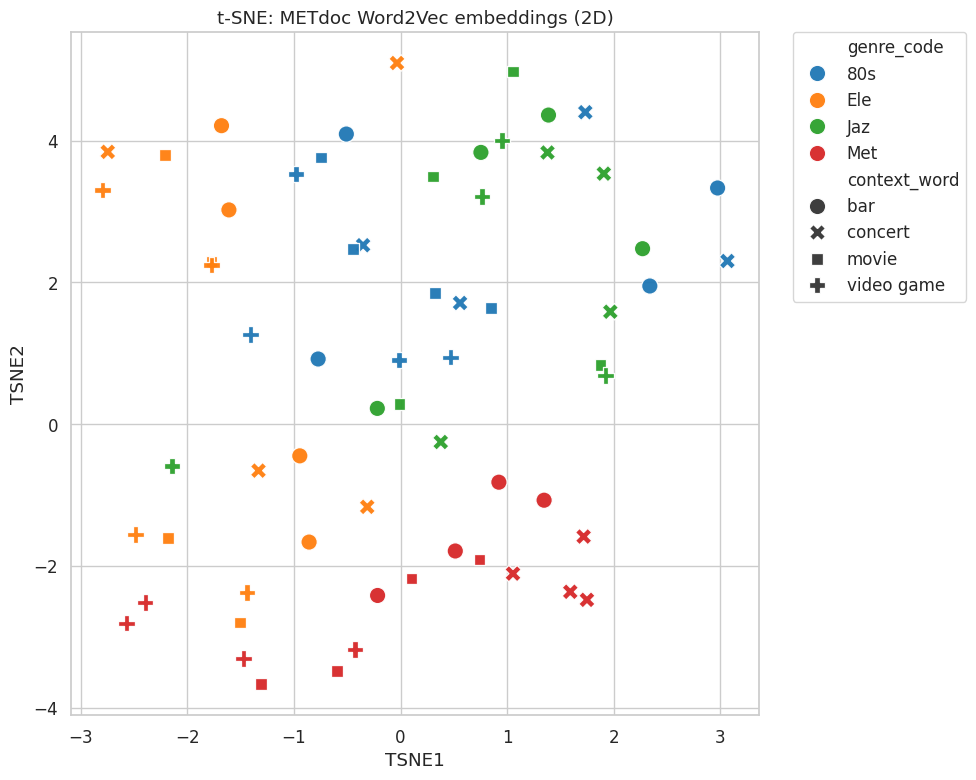

Saved document t-SNE plot to: /content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_tsne_plot.png


In [35]:
# ---------- PLOT (documents) ----------
plt.figure(figsize=(10, 8))
sns.set(style='whitegrid', font_scale=1.1)

# Color by genre (hue), shape by context_word (style) for easy comparison
ax = sns.scatterplot(data=emb_df, x='TSNE1', y='TSNE2',
                     hue='genre_code', style='context_word',
                     palette='tab10', s=140, alpha=0.95)

plt.title('t-SNE: METdoc Word2Vec embeddings (2D)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
png_path = os.path.join(SAVE_DIR, 'METdocs_tsne_plot.png')
plt.savefig(png_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved document t-SNE plot to: {png_path}")


### t-SNE for WORDS (term vectors)

Preparing word-level t-SNE (Word2Vec term vectors)...
Selected 500 top terms present in Word2Vec model (requested TOP_N_WORDS=500).


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Saved word t-SNE coords to: /content/context-framed-listening/NLP_outputs/Word2Vec/word_tsne_top500.csv


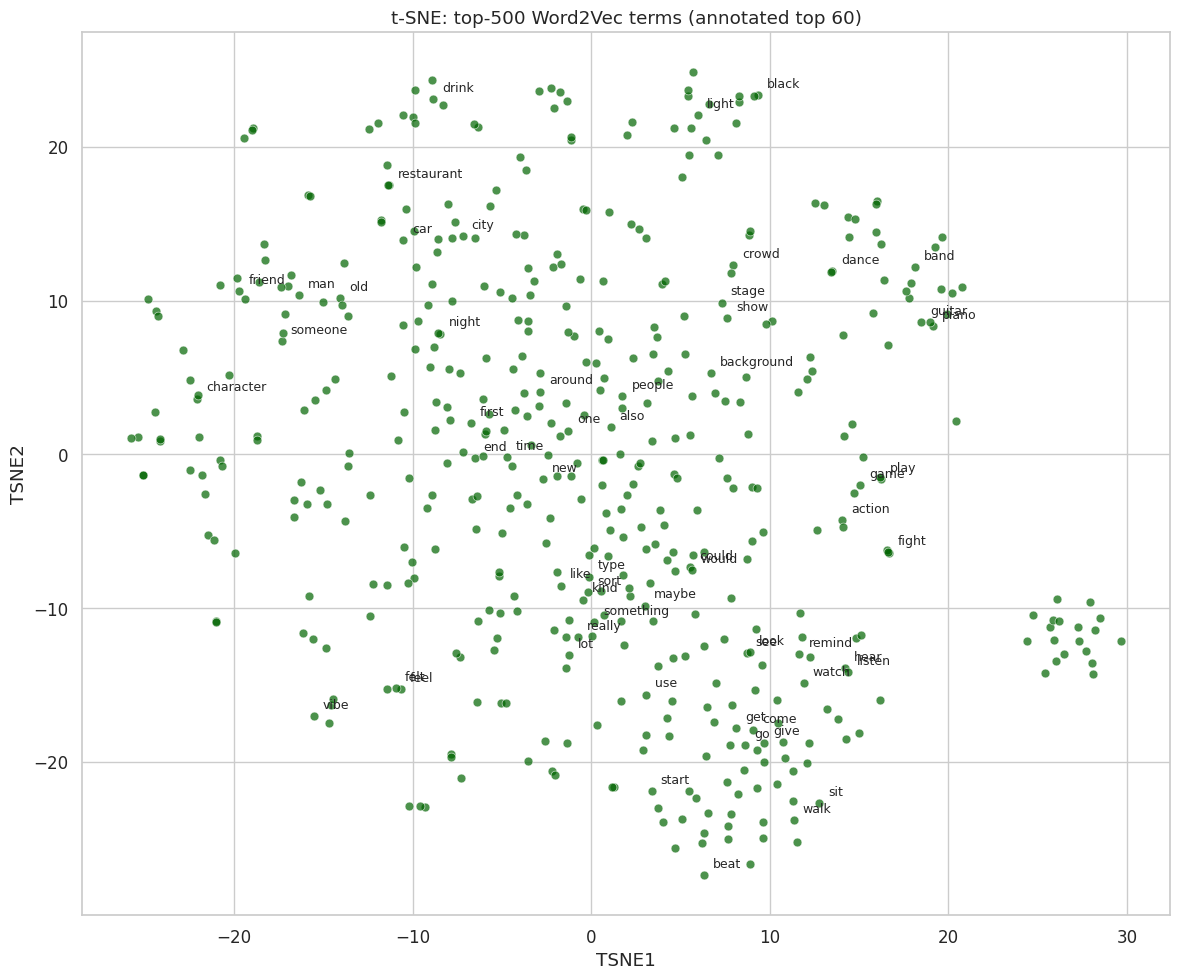

Saved word t-SNE plot to: /content/context-framed-listening/NLP_outputs/Word2Vec/word_tsne_top500.png


In [36]:
# ---------- OPTIONAL: t-SNE for WORDS (using Word2Vec vectors) ----------
if DO_WORD_TSNE and model is not None:
    print("Preparing word-level t-SNE (Word2Vec term vectors)...")

    # Tokenize all METdoc text and count frequencies
    all_text = METdocs[text_column].astype(str).str.cat(sep=' ')
    tokens = nltk.word_tokenize(all_text.lower())
    freq = Counter(tokens)

    # Filter tokens: alphabetic (optional), not pure punctuation, and present in model vocab
    filtered_terms = [w for w, _ in freq.most_common() if any(c.isalpha() for c in w)]
    # Keep only terms in model
    in_model_terms = [w for w in filtered_terms if w in model.key_to_index]
    top_terms = in_model_terms[:TOP_N_WORDS]
    print(f"Selected {len(top_terms)} top terms present in Word2Vec model (requested TOP_N_WORDS={TOP_N_WORDS}).")

    if len(top_terms) == 0:
        print("No top terms found in model vocabulary; skipping word-level t-SNE.")
    else:
        # Build matrix of word vectors (rows = terms)
        W = np.vstack([model[word] for word in top_terms])

        # Pre-reduce dimensionality if appropriate
        svd_w_components = min(30, W.shape[1] - 1) if W.shape[1] > 1 else 1
        if svd_w_components <= 0:
            svd_w_components = 1
        svd_w = TruncatedSVD(n_components=svd_w_components, random_state=TSNE_RANDOM_STATE)
        W_reduced = svd_w.fit_transform(W)

        # t-SNE on words
        tsne_w = TSNE(n_components=2, perplexity=30, n_iter=TSNE_N_ITER,
                      random_state=TSNE_RANDOM_STATE, init='pca', learning_rate='auto')
        W_emb = tsne_w.fit_transform(W_reduced)

        words_df = pd.DataFrame(W_emb, columns=['TSNE1', 'TSNE2'])
        words_df['term'] = top_terms
        words_csv = os.path.join(SAVE_DIR, f'word_tsne_top{len(top_terms)}.csv')
        words_df.to_csv(words_csv, index=False)
        print(f"Saved word t-SNE coords to: {words_csv}")

        # Plot words, annotate a subset (to reduce overlap)
        plt.figure(figsize=(12, 10))
        sns.scatterplot(data=words_df, x='TSNE1', y='TSNE2', s=40, color='darkgreen', alpha=0.7)
        # Annotate top K highest-frequency words (to avoid overcrowding)
        annotate_terms = [w for w, _ in freq.most_common() if w in top_terms][:ANNOTATE_K]
        for _, row in words_df[words_df['term'].isin(annotate_terms)].iterrows():
            plt.text(row['TSNE1'] + 0.5, row['TSNE2'] + 0.5, row['term'], fontsize=9)
        plt.title(f't-SNE: top-{len(top_terms)} Word2Vec terms (annotated top {len(annotate_terms)})')
        plt.tight_layout()
        words_png = os.path.join(SAVE_DIR, f'word_tsne_top{len(top_terms)}.png')
        plt.savefig(words_png, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Saved word t-SNE plot to: {words_png}")


In [37]:
# ---------- FINISHED ----------
print("t-SNE (Word2Vec) complete. Adjust SVD_COMPONENTS / TSNE_PERPLEXITY / TOP_N_WORDS as needed.")

t-SNE (Word2Vec) complete. Adjust SVD_COMPONENTS / TSNE_PERPLEXITY / TOP_N_WORDS as needed.


---
## ANALYSIS AT INDIVIDUAL MET LEVEL


Load in the data file "**dataMET_preprocessed.csv**" that contains the preprocessed text data of participants' thought desciptions, generated using the code notebook titled [framed_listening_text_prep](https://github.com/HazelvdW/context-framed-listening/blob/main/framed_listening_text_prep.ipynb)

In [ ]:
print("Loading preprocessed MET data...")
dataMETpre = pd.read_csv("/content/context-framed-listening/NLP_outputs/dataMET_preprocessed.csv")

# Use the Word2Vec-appropriate preprocessing column (aggressive filtering)
thought_column = 'METdescr_prepLVL2'

print(f"Total individual MET descriptions for analysis: {len(dataMETpre)}")
print(f"Unique clips: {dataMETpre['clip_name'].nunique()}")
print(f"Unique contexts: {dataMETpre['context_word'].nunique()}")
print(f"Unique clip-context pairs: {dataMETpre['clip_context_PAIR'].nunique()}")

### Word2Vec embeddings

In [ ]:
print("\nComputing Word2Vec embeddings for individual thoughts...")
print("This may take several minutes for ~2000 thoughts...")

embeddings = []
all_missing_words = []

for idx, row in dataMETpre.iterrows():
    text = str(row[thought_column])
    embedding, missing_words = get_word2vec_embedding(text, model_word2vec)
    embeddings.append(embedding)
    all_missing_words.extend(missing_words)

    if (idx + 1) % 200 == 0:
        print(f"  Processed {idx + 1}/{len(dataMETpre)} thoughts...")

embeddings = np.array(embeddings)
print(f"\nWord2Vec embeddings shape: {embeddings.shape}")
print(f"Unique words not in vocabulary: {len(set(all_missing_words))}")

# Save embeddings for reuse
np.save('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_embeddings_W2V.npy',
        embeddings)
print("Embeddings saved")

### Pairwise Cosine Similarity

In [ ]:
print("\nCalculating pairwise cosine similarity matrix...")
print(f"This creates a {len(dataMETpre)} x {len(dataMETpre)} matrix...")

cosine_matrix = cosine_similarity(embeddings, embeddings)

# Save full similarity matrix
cosine_df = pd.DataFrame(
    cosine_matrix,
    index=dataMETpre.index,
    columns=dataMETpre.index
)
cosine_df.to_csv('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_cosine_matrix_W2V.csv')
print("Cosine similarity matrix saved")

### Similarity Values by Condition

In [ ]:
print("\nExtracting similarity values for each condition...")

# Initialize storage for similarity measures
similarity_data = {
    'thought_i': [],
    'thought_j': [],
    'similarity': [],
    'same_clip': [],
    'same_context': [],
    'same_genre': [],
    'same_participant': [],
    'condition': []
}

# Extract metadata for efficient comparison
clips = dataMETpre['clip_name'].values
contexts = dataMETpre['context_word'].values
genres = dataMETpre['clip_genre'].values
participants = dataMETpre['participant_id'].values if 'participant_id' in dataMETpre.columns else np.zeros(len(dataMETpre))

# Iterate through upper triangle of similarity matrix (avoid duplicates)
n_thoughts = len(dataMETpre)
total_pairs = (n_thoughts * (n_thoughts - 1)) // 2
print(f"Processing {total_pairs:,} unique thought pairs...")

for i in range(n_thoughts):
    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{n_thoughts} thoughts...")

    for j in range(i + 1, n_thoughts):
        # Extract similarity value
        sim_value = cosine_matrix[i, j]

        # Determine conditions
        same_clip = clips[i] == clips[j]
        same_context = contexts[i] == contexts[j]
        same_genre = genres[i] == genres[j]
        same_participant = participants[i] == participants[j]

        # Categorize into primary conditions for the research question
        if same_clip and same_context:
            condition = 'sameClip_sameContext'
        elif same_clip and not same_context:
            condition = 'sameClip_diffContext'  # KEY: Music influence
        elif not same_clip and same_context:
            condition = 'diffClip_sameContext'  # KEY: Context influence
        elif not same_clip and not same_context:
            if same_genre:
                condition = 'diffClip_diffContext_sameGenre'
            else:
                condition = 'diffClip_diffContext_diffGenre'

        # Store data
        similarity_data['thought_i'].append(i)
        similarity_data['thought_j'].append(j)
        similarity_data['similarity'].append(sim_value)
        similarity_data['same_clip'].append(same_clip)
        similarity_data['same_context'].append(same_context)
        similarity_data['same_genre'].append(same_genre)
        similarity_data['same_participant'].append(same_participant)
        similarity_data['condition'].append(condition)

# Create DataFrame
sim_df = pd.DataFrame(similarity_data)
sim_df.to_csv('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_similarity_by_condition_W2V.csv',
              index=False)

print("\nSimilarity measures extracted")
print("\nCondition summary:")
print(sim_df.groupby('condition')['similarity'].agg(['count', 'mean', 'std', 'min', 'max']))


### STATISTICAL ANALYSES

1. PRIMARY RESEARCH QUESTION: Music vs Context Influence
2. Genre Effects
3. Context Specificity
4. Music Specificity
5. OMNIBUS TEST
6. Effect Size Ranking

In [ ]:
def compare_conditions(df, cond1, cond2, label1, label2):
    """Compare two conditions with t-test and effect size."""
    data1 = df[df['condition'] == cond1]['similarity']
    data2 = df[df['condition'] == cond2]['similarity']

    t_stat, p_value = stats.ttest_ind(data1, data2)

    # Cohen's d
    pooled_std = np.sqrt((data1.std()**2 + data2.std()**2) / 2)
    effect_size = (data1.mean() - data2.mean()) / pooled_std

    if p_value < 0.001:
        sig_str = "***"
    elif p_value < 0.01:
        sig_str = "**"
    elif p_value < 0.05:
        sig_str = "*"
    else:
        sig_str = "n.s."

    return {
        'comparison': f"{label1} vs {label2}",
        'mean1': data1.mean(),
        'mean2': data2.mean(),
        'diff': data1.mean() - data2.mean(),
        't': t_stat,
        'p': p_value,
        'sig': sig_str,
        'd': effect_size,
        'n1': len(data1),
        'n2': len(data2)
    }

# Store all comparison results
comparisons = []


# 1. PRIMARY RESEARCH QUESTION: Music vs Context Influence
# ----------------------------------------------------------------------------
print("\n1. PRIMARY QUESTION: Music vs Context Influence")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'sameClip_diffContext',
    'diffClip_sameContext',
    'Same Music, Diff Context',
    'Diff Music, Same Context'
)
comparisons.append(comp)

print(f"\nSame music, different context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different music, same context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"Difference: {comp['diff']:.4f}")
print(f"t({comp['n1'] + comp['n2'] - 2}) = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}")
print(f"Cohen's d = {comp['d']:.3f}")

if comp['mean1'] > comp['mean2']:
    print("\n→ MUSIC drives thought similarity MORE than context")
else:
    print("\n→ CONTEXT drives thought similarity MORE than music")


# 2. GENRE EFFECTS
# ----------------------------------------------------------------------------
print("\n\n2. GENRE EFFECTS")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'diffClip_diffContext_sameGenre',
    'diffClip_diffContext_diffGenre',
    'Different everything, Same Genre',
    'Different everything, Different Genre'
)
comparisons.append(comp)

print(f"\nSame genre (diff clip & context): M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different genre (diff clip & context): M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

if comp['sig'] != 'n.s.':
    print("\n→ Genre creates semantic coherence even across different clips and contexts")
else:
    print("\n→ Genre does NOT significantly affect thought similarity")


# 3. CONTEXT SPECIFICITY
# ----------------------------------------------------------------------------
print("\n\n3. CONTEXT SPECIFICITY: How much does context alone matter?")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'sameClip_sameContext',
    'diffClip_sameContext',
    'Same Context & Same Clip',
    'Same Context, Diff Clip'
)
comparisons.append(comp)

print(f"\nSame context + same clip: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same context, different clip: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

print("\n→ This shows whether identical stimuli create MORE similarity than just shared context")


# 4. MUSIC SPECIFICITY
# ----------------------------------------------------------------------------
print("\n\n4. MUSIC SPECIFICITY: How much does the specific clip alone matter?")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'sameClip_sameContext',
    'sameClip_diffContext',
    'Same Clip & Same Context',
    'Same Clip, Diff Context'
)
comparisons.append(comp)

print(f"\nSame clip + same context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same clip, different context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

print("\n→ This shows whether identical stimuli create MORE similarity than just shared music")


# 5. OMNIBUS TEST
# ----------------------------------------------------------------------------
print("\n\n5. OMNIBUS TEST: Do conditions differ overall?")
print("-" * 70)

conditions = sim_df['condition'].unique()
groups = [sim_df[sim_df['condition'] == cond]['similarity'] for cond in conditions]
f_stat, p_anova = stats.f_oneway(*groups)

print(f"\nOne-way ANOVA across all {len(conditions)} conditions:")
print(f"F({len(conditions)-1}, {len(sim_df)-len(conditions)}) = {f_stat:.3f}, p = {p_anova:.4e}")

if p_anova < 0.001:
    print("\n→ Conditions are HIGHLY significantly different overall")
else:
    print("\n→ Conditions show significant differences" if p_anova < 0.05 else "→ No significant differences")


# 6. EFFECT SIZE RANKING
# ----------------------------------------------------------------------------
print("\n\n6. EFFECT SIZE RANKING: Which comparisons matter most?")
print("-" * 70)

condition_means = sim_df.groupby('condition')['similarity'].agg(['mean', 'std', 'count'])
condition_means = condition_means.sort_values('mean', ascending=False)

print("\nCondition means (ranked):")
print(condition_means)

# Save comparison results
comparisons_df = pd.DataFrame(comparisons)
comparisons_df = comparisons_df.sort_values('d', key=abs, ascending=False)
comparisons_df.to_csv('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_statistical_comparisons_W2V.csv', index=False)

print("\n\nKey comparisons ranked by effect size:")
print(comparisons_df[['comparison', 'diff', 'd', 'p', 'sig']])

### Visualisations

1. PRIMARY COMPARISON: Music vs Context
2. ALL CONDITIONS comparison
3. Bar plot with means and 95% CI
4. Distribution comparison histogram (Music vs Context)
5. HIERARCHICAL comparison showing all levels
6. Genre effects visualisation
7. Heatmap showing mean similarities between conditions

In [ ]:
print("\nGenerating visualisations...")

# Get data for key conditions
music_driven = sim_df[sim_df['condition'] == 'sameClip_diffContext']['similarity']
context_driven = sim_df[sim_df['condition'] == 'diffClip_sameContext']['similarity']
same_both = sim_df[sim_df['condition'] == 'sameClip_sameContext']['similarity']
diff_both_same_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_sameGenre']['similarity']
diff_both_diff_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_diffGenre']['similarity']


# 1. PRIMARY COMPARISON: Music vs Context
fig, ax = plt.subplots(figsize=(10, 6))
comparison_data = sim_df[sim_df['condition'].isin(['sameClip_diffContext', 'diffClip_sameContext'])]
sns.boxplot(data=comparison_data, x='condition', y='similarity', ax=ax,
            hue='condition', palette=['#3498db', '#e74c3c'])
sns.stripplot(data=comparison_data, x='condition', y='similarity', ax=ax,
              hue='condition', palette='dark:black', alpha=0.2, size=2)
ax.set_title('PRIMARY QUESTION: Music vs Context Influence on Thought Similarity',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (Word2Vec)', fontsize=12)
ax.set_xticklabels(['Same Music\nDifferent Context', 'Different Music\nSame Context'])
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_01_music_vs_context_boxplot_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 2. ALL CONDITIONS comparison
fig, ax = plt.subplots(figsize=(14, 7))
condition_order = sim_df.groupby('condition')['similarity'].mean().sort_values(ascending=False).index
sns.violinplot(data=sim_df, x='condition', y='similarity', ax=ax, order=condition_order,
               hue='condition', palette='viridis')
ax.set_title('Thought Similarity Distributions Across All Conditions', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (Word2Vec)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_02_all_conditions_violin_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 3. Bar plot with means and 95% CI
fig, ax = plt.subplots(figsize=(14, 7))
means = sim_df.groupby('condition')['similarity'].mean().sort_values(ascending=False)
sems = sim_df.groupby('condition')['similarity'].sem()
ci95 = sems * 1.96

means.plot(kind='bar', ax=ax, yerr=ci95, capsize=5, color='steelblue',
           edgecolor='black', alpha=0.8, error_kw={'linewidth': 2})
ax.set_title('Mean Similarity by Condition (with 95% CI)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Mean Cosine Similarity (Word2Vec)', fontsize=12)
ax.set_xticklabels(means.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=sim_df['similarity'].mean(), color='red', linestyle='--',
           alpha=0.5, label='Overall Mean')
ax.legend()
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_03_condition_means_barplot_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 4. Distribution comparison histogram (Music vs Context)
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(music_driven, bins=50, alpha=0.5, label='Same Music, Diff Context', color='#3498db', density=True)
ax.hist(context_driven, bins=50, alpha=0.5, label='Diff Music, Same Context', color='#e74c3c', density=True)
ax.axvline(music_driven.mean(), color='#3498db', linestyle='--', linewidth=2.5,
           label=f'Music Mean: {music_driven.mean():.3f}')
ax.axvline(context_driven.mean(), color='#e74c3c', linestyle='--', linewidth=2.5,
           label=f'Context Mean: {context_driven.mean():.3f}')
ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution Comparison: Music vs Context Influence', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_04_music_vs_context_histogram_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 5. HIERARCHICAL comparison showing all levels
fig, ax = plt.subplots(figsize=(12, 7))
hierarchical_data = sim_df[sim_df['condition'].isin([
    'sameClip_sameContext',
    'sameClip_diffContext',
    'diffClip_sameContext',
    'diffClip_diffContext_sameGenre',
    'diffClip_diffContext_diffGenre'
])]

order = ['sameClip_sameContext', 'sameClip_diffContext', 'diffClip_sameContext',
         'diffClip_diffContext_sameGenre', 'diffClip_diffContext_diffGenre']
labels = ['Both Same', 'Music Same\nContext Diff', 'Context Same\nMusic Diff',
          'Both Diff\nGenre Same', 'Both Diff\nGenre Diff']

sns.boxplot(data=hierarchical_data, x='condition', y='similarity', ax=ax,
            order=order, hue='condition', palette='RdYlGn_r')
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_title('Hierarchical Similarity: From Complete Match to Complete Difference',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (Word2Vec)', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_05_hierarchical_comparison_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 6. Genre effects visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

genre_comparison = sim_df[sim_df['condition'].isin([
    'diffClip_diffContext_sameGenre',
    'diffClip_diffContext_diffGenre'
])]
sns.boxplot(data=genre_comparison, x='condition', y='similarity', ax=axes[0],
            hue='condition', palette=['#2ecc71', '#95a5a6'])
axes[0].set_title('Genre Effect\n(Different Clip & Context)', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Same Genre', 'Different Genre'])
axes[0].set_ylabel('Cosine Similarity (Word2Vec)', fontsize=11)
axes[0].set_xlabel('')

all_conditions_means = sim_df.groupby('condition')['similarity'].mean()
all_conditions_means.sort_values(ascending=True).plot(kind='barh', ax=axes[1],
                                                       color='steelblue', edgecolor='black')
axes[1].set_title('Mean Similarity: All Conditions', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mean Cosine Similarity (Word2Vec)', fontsize=11)
axes[1].set_ylabel('')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_06_genre_effects_summary_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 7. Heatmap showing mean similarities between conditions
fig, ax = plt.subplots(figsize=(10, 8))
condition_pivot = sim_df.pivot_table(values='similarity',
                                      index='condition',
                                      aggfunc='mean').sort_values('similarity', ascending=False)
sns.heatmap(condition_pivot, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Mean Cosine Similarity'}, ax=ax)
ax.set_title('Mean Similarity by Condition (Heatmap)', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_07_condition_heatmap_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

### SUMMARY

In [ ]:
print("\n" + "-"*70)
print("INDIVIDUAL-LEVEL ANALYSIS COMPLETE")
print("-"*70)

print("\nOutput files saved:")
print("\n  Data files:")
print("    - indvMET_embeddings_W2V.npy")
print("    - indvMET_cosine_matrix_W2V.csv")
print("    - indvMET_similarity_by_condition_W2V.csv")
print("    - indvMET_statistical_comparisons_W2V.csv")

print("\n  Visualisations:")
print("    - indvMET_01_music_vs_context_boxplot_W2V.png")
print("    - indvMET_02_all_conditions_violin_W2V.png")
print("    - indvMET_03_condition_means_barplot_W2V.png")
print("    - indvMET_04_music_vs_context_histogram_W2V.png")
print("    - indvMET_05_hierarchical_comparison_W2V.png")
print("    - indvMET_06_genre_effects_summary_W2V.png")
print("    - indvMET_07_condition_heatmap_W2V.png")

print("\n" + "-"*70)
print("KEY FINDINGS SUMMARY")
print("-"*70)

music_driven_summary = sim_df[sim_df['condition'] == 'sameClip_diffContext']['similarity']
context_driven_summary = sim_df[sim_df['condition'] == 'diffClip_sameContext']['similarity']
diff = music_driven_summary.mean() - context_driven_summary.mean()
t_stat, p_value = stats.ttest_ind(music_driven_summary, context_driven_summary)
effect_size = diff / np.sqrt((music_driven_summary.std()**2 + context_driven_summary.std()**2) / 2)

print("\n1. PRIMARY RESEARCH QUESTION: Music vs Context")
if abs(diff) < 0.01:
    print(f"   → Music and context have EQUIVALENT influence (d={effect_size:.3f})")
elif music_driven_summary.mean() > context_driven_summary.mean():
    print(f"   → MUSIC drives thought similarity MORE than context")
    print(f"   → Difference: {diff:.4f} (d={effect_size:.3f}, p={p_value:.4f})")
else:
    print(f"   → CONTEXT drives thought similarity MORE than music")
    print(f"   → Difference: {abs(diff):.4f} (d={abs(effect_size):.3f}, p={p_value:.4f})")

same_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_sameGenre']['similarity'].mean()
diff_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_diffGenre']['similarity'].mean()
print(f"\n2. GENRE EFFECTS")
print(f"   → Same genre: M={same_genre:.4f}")
print(f"   → Different genre: M={diff_genre:.4f}")
print(f"   → Difference: {same_genre - diff_genre:.4f}")

same_both = sim_df[sim_df['condition'] == 'sameClip_sameContext']['similarity'].mean()
print(f"\n3. BASELINE (identical stimuli): M={same_both:.4f}")

print("\n" + "~"*70)